# Time Series Forecasting - Layoffs and Job Postings

## Setup

### Import Statements

In [84]:
import pandas as pd
import numpy as np

import string
import re
import datetime
#from datetime import date

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pylab import rcParams
import seaborn as sns

from jupyter_dash import JupyterDash as Dash
from dash import html 
from flask import Flask
import plotly.express as px

from statsmodels.tools.sm_exceptions import ConvergenceWarning
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

plt.style.use('ggplot')

### Load in Data

In [85]:
total_layoffs_by_month = pd.read_csv('data/monthly_layoffs.csv')
layoffs = pd.read_csv('data/layoffs.csv')
job_postings_national = pd.read_csv('data/job_postings.csv')

In [86]:
# visually inspecting

display(total_layoffs_by_month.head())
display(layoffs.head())

,month,total_laid_off
0,2020-03-01,9628.0
1,2020-04-01,26710.0
2,2020-05-01,25804.0
3,2020-06-01,7627.0
4,2020-07-01,7112.0


,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Google,SF Bay Area,Consumer,12000.0,0.06,2023-01-20,IPO,United States,26.0
1,Wayfair,Boston,Retail,1750.0,0.10,2023-01-20,IPO,United States,1700.0
2,Swiggy,Bengaluru,Food,380.0,0.06,2023-01-20,Unknown,India,3600.0
3,MediBuddy,Bengaluru,Healthcare,200.0,NaN,2023-01-20,Acquired,India,192.0
4,Vox Media,Washington D.C.,Media,130.0,0.07,2023-01-20,Series F,United States,307.0


## Useful Functions

In [87]:
#Plot rolling statistics
def check_stationarity(df, window, values):
    
    '''
    df includes index
    window is int (representing period of time)
    values are x values in df (1d array)
    '''
    
    moving_avg = df.rolling(window).mean() # 4 week lag
    moving_std = df.rolling(window).std()

    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
    std = plt.plot(moving_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=45)
    plt.show(block=False)

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(values, autolag='AIC')

    # Extract and display test results
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used',
                                'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
# mean and standard deviation increasing with time = not stationary

In [128]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

## Job Postings

In [32]:
job_postings_national.head() # should get rid of first column (extra index)

,Unnamed: 0,year,month,day_endofweek,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5,date
0,0,2020,1,10,-0.0407,-0.0748,-0.0399,-0.104,-0.1020,0.00711,0.0629,-0.0013,-0.00683,-0.0723,-0.0646,-0.0512,-0.0889,2020-01-10
1,1,2020,1,17,0.1180,0.0922,0.0660,0.170,0.2240,0.07930,0.0934,0.1120,0.11400,0.1730,0.1260,0.0656,0.2060,2020-01-17
2,2,2020,1,24,-0.0954,-0.0819,-0.1020,-0.117,-0.1520,-0.02490,-0.0591,-0.0570,-0.05680,-0.1170,-0.1150,-0.0985,-0.1640,2020-01-24
3,3,2020,1,31,0.0183,0.0645,0.0758,0.051,0.0292,-0.06150,-0.0973,-0.0538,-0.05010,0.0168,0.0535,0.0841,0.0465,2020-01-31
4,4,2020,2,7,-0.0943,-0.1200,-0.0350,-0.121,-0.0890,-0.09110,-0.0294,-0.0901,-0.09540,-0.1030,-0.1000,-0.0933,-0.1140,2020-02-07


In [44]:
df = job_postings_national[['date', 'bg_posts']]
df.head()

,date,bg_posts
0,2020-01-10,-0.0407
1,2020-01-17,0.1180
2,2020-01-24,-0.0954
3,2020-01-31,0.0183
4,2020-02-07,-0.0943


In [35]:
df.asfreq('W-FRI')

,date,bg_posts


In [48]:
df = job_postings_national[['date', 'bg_posts']]

# index needs to be DatetimeIndex named "date"
if isinstance(df.index, pd.DatetimeIndex):
    df.index.name = 'date'
else:
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
# weekly frequency, on Fridays 
#df = df['bg_posts'].resample('W-FRI').mean()
df = df.asfreq('W-FRI')
df.head()

#### Stationarity Check & Trend Visualization

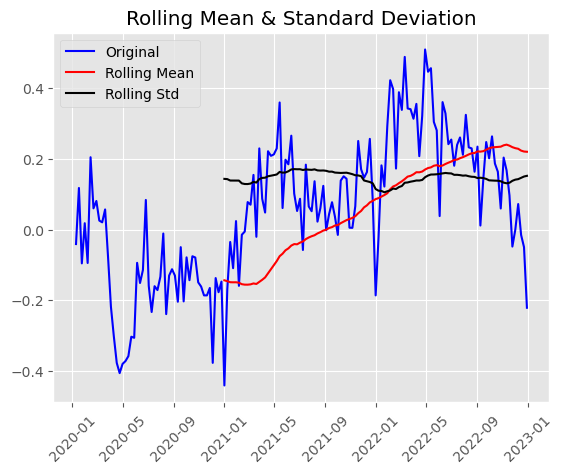

Results of Dickey-Fuller Test:
Test Statistic                  -1.823939
p-value                          0.368643
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [53]:
# dickey fuller test to check stationarity - 52 week window
check_stationarity(df, 52, df['bg_posts'])

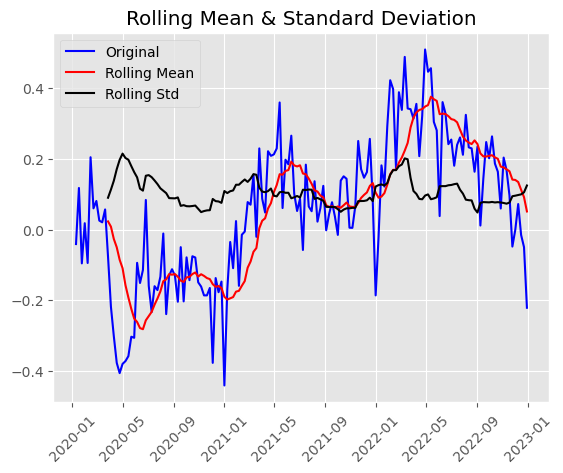

Results of Dickey-Fuller Test:
Test Statistic                  -1.823939
p-value                          0.368643
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [54]:
# dickey Fuller test to check stationarity - 12 week window
check_stationarity(df, 12, df['bg_posts'])

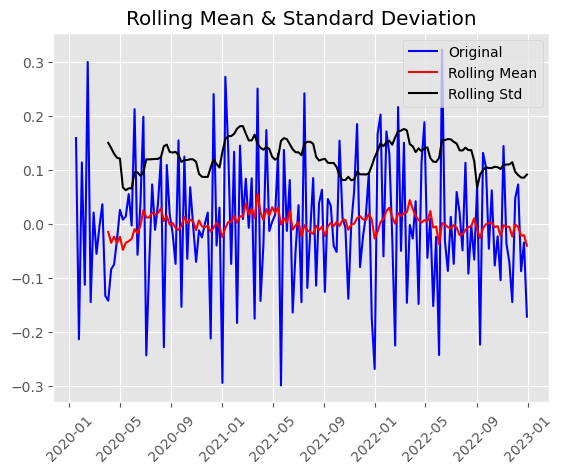

Results of Dickey-Fuller Test:
Test Statistic                -9.817304e+00
p-value                        5.454309e-17
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [60]:
# this looks stationary, implies one degree of differencing needed
check_stationarity(df.diff(), 12, df['bg_posts'].diff().dropna())

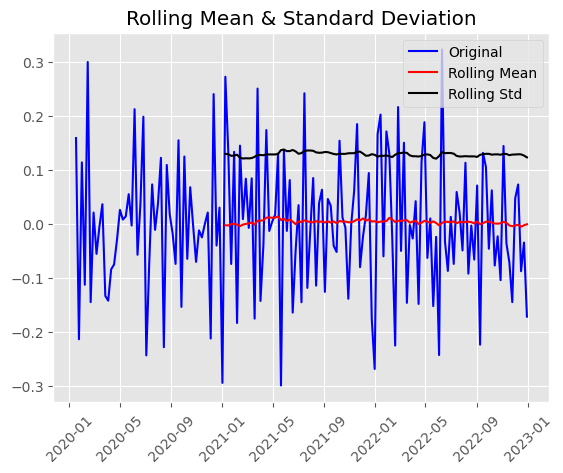

Results of Dickey-Fuller Test:
Test Statistic                -9.817304e+00
p-value                        5.454309e-17
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [59]:
# this looks stationary, implies one degree of differencing needed
check_stationarity(df.diff(), 52, df['bg_posts'].diff().dropna())

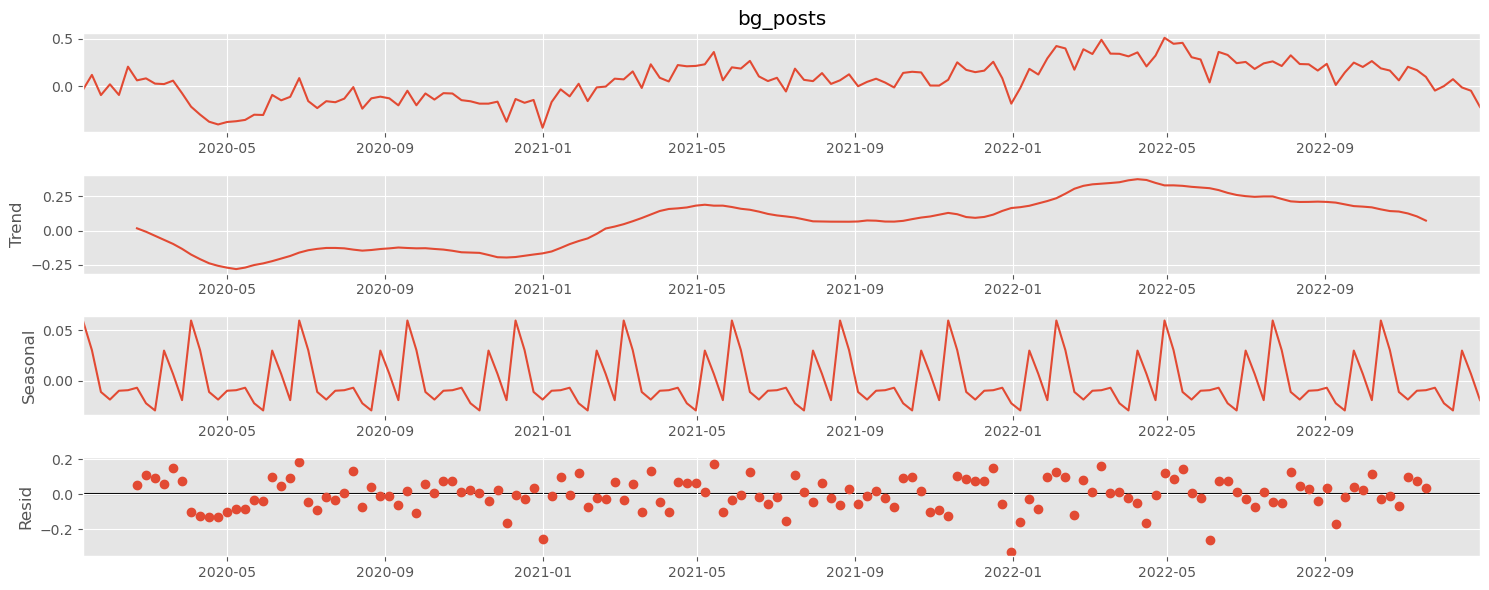

In [176]:
sd = seasonal_decompose(df, period=12)
sd.plot()
plt.show()

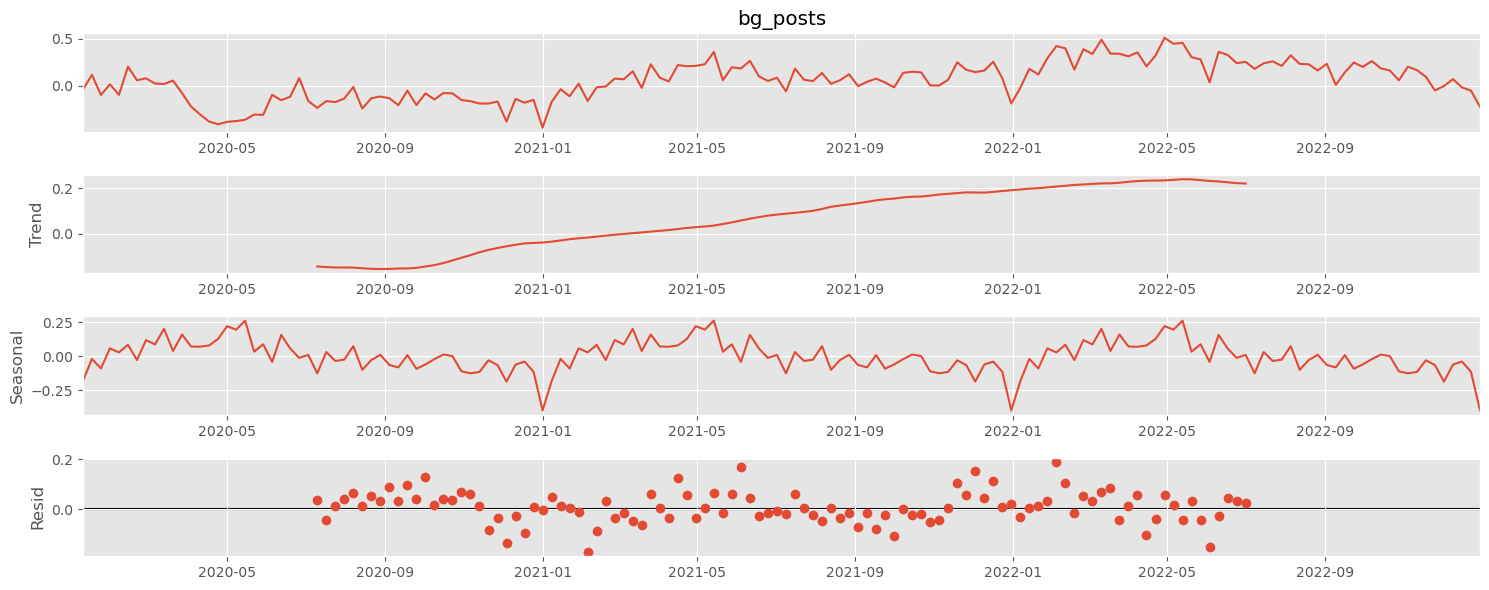

In [175]:
sd = seasonal_decompose(df, period=52)
sd.plot()
plt.show()

<AxesSubplot: xlabel='date'>

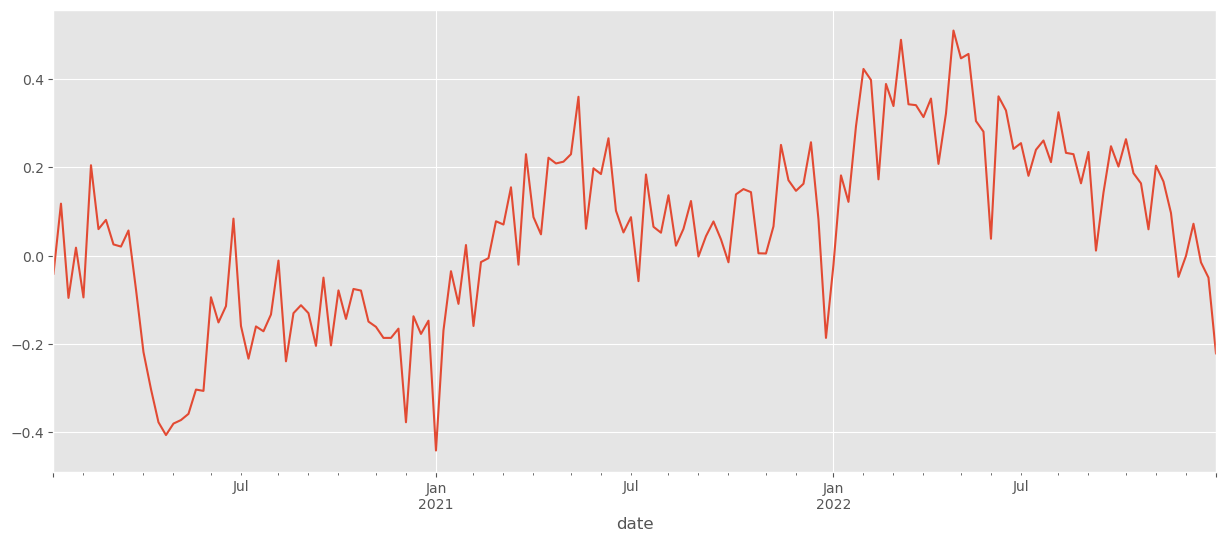

In [118]:
diff = df.dropna()
diff.plot()

<AxesSubplot: xlabel='date'>

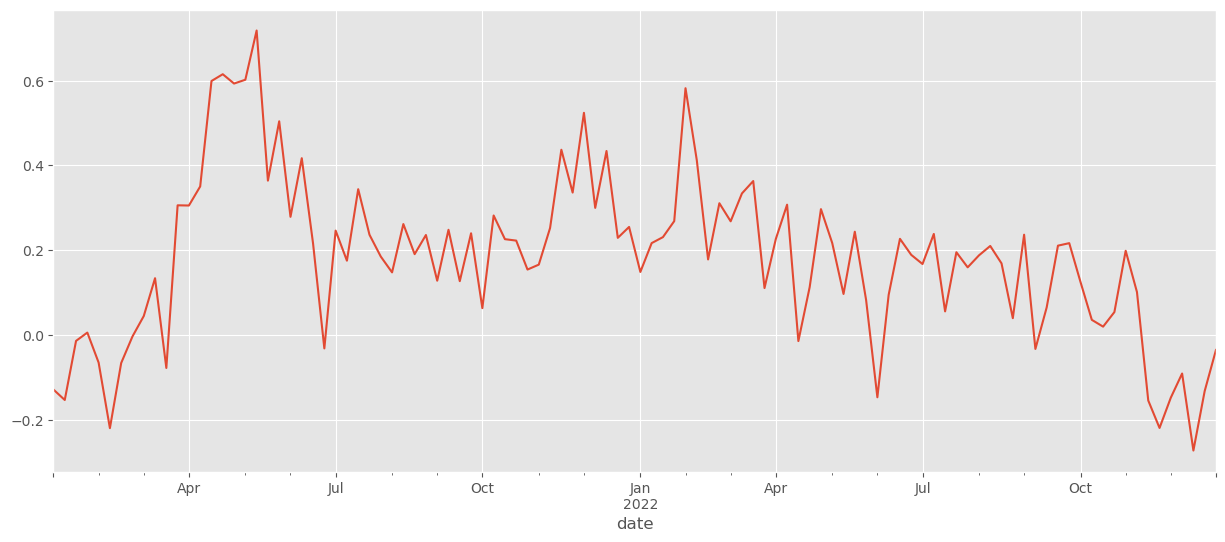

In [117]:
df_s_adj = diff - diff.shift(52)
df_s_adj = df_s_adj.dropna()
df_s_adj.plot()

In [77]:
df_monthly = df['bg_posts'].resample('MS').mean() # monthly frequency

df = df['bg_posts'].resample('W-FRI').mean()
df = df.fillna(df.bfill())
df.head()

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

In [579]:
sd = seasonal_decompose(df_monthly, period=12)
sd.plot()
plt.show()

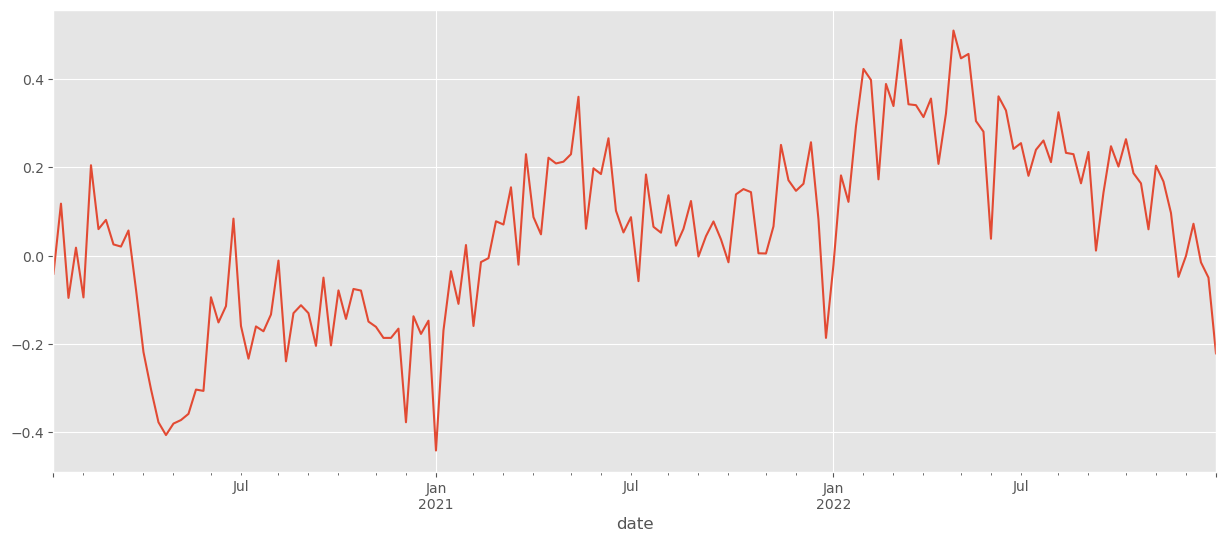

In [54]:
df.plot(figsize=(15, 6))
plt.show()

In [61]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 52 for frequency - yearly)
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [62]:
results = []

for comb in pdq:
    
    for combs in pdqs:
        
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=df,
                                            order=comb,
                                            seasonal_order=combs)
                                            #enforce_invertibility=False, 
                                            #enforce_stationarity=False)

            output = mod.fit()
            results.append([comb, combs, output.aic])
            
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        
        except: 
            continue

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40399D-01    |proj g|=  2.26146D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     16      1     0     0   2.261D-04  -1.404D-01
  F = -0.14039867915566170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (0, 0, 0, 52): AIC Calculated=-41.80438789656645
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0       

 This problem is unconstrained.



At iterate   10    f= -1.51941D-01    |proj g|=  1.00551D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     16      1     0     0   9.248D-05  -1.519D-01
  F = -0.15194065710788707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (0, 0, 1, 52): AIC Calculated=-43.405485017660766
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28667D-02    |proj g|=  1.53860D+00

At iterate    5    f=  6.13551D-02    |proj g|=  1.09426D-06

 

 This problem is unconstrained.


ARIMA (0, 0, 0) x (0, 1, 0, 52): AIC Calculated=21.142788765382164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48267D-01    |proj g|=  3.14050D+00


 This problem is unconstrained.



At iterate    5    f=  5.41722D-02    |proj g|=  6.27420D-02

At iterate   10    f=  5.39000D-02    |proj g|=  9.69997D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     16      1     0     0   9.700D-06   5.390D-02
  F =   5.3899981440039199E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 1, 52): AIC Calculated=20.81679420929223
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42242D-01    |proj g|=  1.78347D-01


 This problem is unconstrained.



At iterate    5    f= -1.42620D-01    |proj g|=  9.14297D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     11      1     0     0   6.605D-07  -1.426D-01
  F = -0.14262041796551489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 0, 0, 52): AIC Calculated=-40.497570405240644
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38915D-01    |proj g|=  3.90152D-01


 This problem is unconstrained.



At iterate    5    f= -1.44182D-01    |proj g|=  1.74486D-01

At iterate   10    f= -1.48081D-01    |proj g|=  5.01669D-01

At iterate   15    f= -1.71927D-01    |proj g|=  6.20964D-03

At iterate   20    f= -1.72682D-01    |proj g|=  9.75467D-03

At iterate   25    f= -1.72939D-01    |proj g|=  1.06627D-02

At iterate   30    f= -1.72967D-01    |proj g|=  6.71227D-03

At iterate   35    f= -1.72972D-01    |proj g|=  1.61381D-03

At iterate   40    f= -1.72973D-01    |proj g|=  4.04139D-04

At iterate   45    f= -1.72973D-01    |proj g|=  3.21192D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     46     51   

 This problem is unconstrained.



At iterate    5    f=  5.42982D-02    |proj g|=  2.17962D-02

At iterate   10    f=  5.39000D-02    |proj g|=  3.30572D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     17      1     0     0   2.992D-05   5.390D-02
  F =   5.3899981474985967E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (1, 1, 0, 52): AIC Calculated=20.81679422019562
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48267D-01    |proj g|=  3.14050D+00


 This problem is unconstrained.



At iterate    5    f=  5.39037D-02    |proj g|=  1.15984D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   8.864D-06   5.390D-02
  F =   5.3899981473344932E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 1, 1, 52): AIC Calculated=22.81679421968362
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.50383D-01    |proj g|=  1.81963D+00

At iterate    5    f= -4.00013D-01    |proj g|=  2.94646D-01

At 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -4.01631D-01    |proj g|=  4.97785D-01

At iterate   10    f= -4.19332D-01    |proj g|=  1.91665D-01

At iterate   15    f= -4.20717D-01    |proj g|=  8.76351D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     25      1     0     0   4.993D-05  -4.207D-01
  F = -0.42071720512124228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 0, 1, 52): AIC Calculated=-125.26376799782759
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     32      1     0     0   2.815D-05  -1.338D-01
  F = -0.13380658717496435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 1, 0, 52): AIC Calculated=-37.74765519858888
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.85880D-02    |proj g|=  1.06330D+00

At iterate    5    f= -1.30808D-01    |proj g|=  1.42326D-01

At iterate   10    f= -1.33868D-01    |proj g|=  2.93721D-03

At

 This problem is unconstrained.



At iterate   10    f= -4.12520D-01    |proj g|=  8.00577D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   8.006D-06  -4.125D-01
  F = -0.41251971117187747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (1, 0, 0, 52): AIC Calculated=-122.70614988562576
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.50383D-01    |proj g|=  1.81963D+00


 This problem is unconstrained.



At iterate    5    f= -4.03479D-01    |proj g|=  5.91355D-01

At iterate   10    f= -4.15949D-01    |proj g|=  1.54487D-02

At iterate   15    f= -4.17500D-01    |proj g|=  3.75863D-01

At iterate   20    f= -4.28931D-01    |proj g|=  5.15442D-02

At iterate   25    f= -4.30749D-01    |proj g|=  2.71269D-02

At iterate   30    f= -4.31156D-01    |proj g|=  2.23399D-02

At iterate   35    f= -4.31228D-01    |proj g|=  1.27756D-02

At iterate   40    f= -4.31239D-01    |proj g|=  7.37215D-03

At iterate   45    f= -4.31241D-01    |proj g|=  1.11046D-04

At iterate   50    f= -4.31241D-01    |proj g|=  7.98064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.64202D-02    |proj g|=  1.07709D+00

At iterate    5    f= -1.29619D-01    |proj g|=  1.33454D-01

At iterate   10    f= -1.33815D-01    |proj g|=  2.88217D-02

At iterate   15    f= -1.33883D-01    |proj g|=  5.51474D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   5.515D-05  -1.339D-01
  F = -0.13388344332821206     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0

 This problem is unconstrained.



At iterate    5    f= -1.30901D-01    |proj g|=  1.43991D-01

At iterate   10    f= -1.33757D-01    |proj g|=  1.65486D-02

At iterate   15    f= -1.33883D-01    |proj g|=  7.61857D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   1.200D-05  -1.339D-01
  F = -0.13388339777523345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 1, 1, 52): AIC Calculated=-33.771620105872834
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -6.90367D-01    |proj g|=  1.90289D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   7.475D-06  -6.904D-01
  F = -0.69036725761692341     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (0, 0, 1, 52): AIC Calculated=-211.3945843764801
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96388D-01    |proj g|=  2.84435D+00

At iterate    5    f= -3.29214D-01    |proj g|=  1.87228D-03


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      7     29      1     0     0   3.211D-04  -3.292D-01
  F = -0.32921425134848331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 1, 0, 52): AIC Calculated=-100.71484642072679
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.29199D-01    |proj g|=  1.32453D-01

At iterate    5    f= -3.57544D-01    |proj g|=  1.24111D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     19      1     0     0   3.256D-04  -3.576D-01
  F = -0.35761504171511416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 1, 1, 52): AIC Calculated=-107.57589301511561
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =         

 This problem is unconstrained.


At iterate   10    f= -6.93019D-01    |proj g|=  2.23694D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     14      1     0     0   1.485D-05  -6.930D-01
  F = -0.69301872214144311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 0, 0, 52): AIC Calculated=-212.22184130813025
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.63340D-01    |proj g|=  1.93244D-01


 This problem is unconstrained.



At iterate    5    f= -6.91903D-01    |proj g|=  5.74749D-03

At iterate   10    f= -6.92545D-01    |proj g|=  9.56858D-02

At iterate   15    f= -6.93588D-01    |proj g|=  2.98666D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   2.927D-06  -6.936D-01
  F = -0.69359148546564164     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (1, 0, 1, 52): AIC Calculated=-210.4005434652802
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -3.57571D-01    |proj g|=  2.33972D-02

At iterate   10    f= -3.57615D-01    |proj g|=  3.22859D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     19      1     0     0   9.712D-05  -3.576D-01
  F = -0.35761505060241261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 0, 52): AIC Calculated=-107.57589578795273
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.29199D-01    |proj g|=  1.32453D-01


 This problem is unconstrained.



At iterate    5    f= -3.57601D-01    |proj g|=  4.53462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   5.043D-05  -3.576D-01
  F = -0.35761504637058278     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 1, 52): AIC Calculated=-105.57589446762182
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.75169D-01    |proj g|=  2.54278D-02

At iterate    5    f= -7.75504D-01    |proj g|=  4.77998D-04

 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.96358D-01    |proj g|=  1.07187D-02

At iterate   10    f= -7.96469D-01    |proj g|=  9.63245D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   9.632D-06  -7.965D-01
  F = -0.79646925325065687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 0, 1, 52): AIC Calculated=-242.49840701420493
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.93627D-01    |proj g|=  1.23463D-01

A

 This problem is unconstrained.



At iterate   10    f= -3.93802D-01    |proj g|=  1.37918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     19      1     0     0   1.557D-04  -3.938D-01
  F = -0.39380188647585446     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 0, 52): AIC Calculated=-118.8661885804666


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.93627D-01    |proj g|=  1.25489D-01

At iterate    5    f= -4.21083D-01    |proj g|=  8.60838D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     18      1     0     0   1.062D-05  -4.211D-01
  F = -0.42111750218689648     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 1, 52): AIC Calculated=-125.3886606823117
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 

 This problem is unconstrained.



At iterate    5    f= -7.98685D-01    |proj g|=  7.47048D-02

At iterate   10    f= -7.98750D-01    |proj g|=  8.50735D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   6.335D-06  -7.987D-01
  F = -0.79874974501756824     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (1, 0, 0, 52): AIC Calculated=-243.2099204454813
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.75169D-01    |proj g|=  1.69167D-01


 This problem is unconstrained.



At iterate    5    f= -7.97721D-01    |proj g|=  9.17240D-03

At iterate   10    f= -7.97847D-01    |proj g|=  6.87711D-02

At iterate   15    f= -7.97950D-01    |proj g|=  8.46778D-02

At iterate   20    f= -7.98973D-01    |proj g|=  1.43566D-01

At iterate   25    f= -7.99518D-01    |proj g|=  3.59768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   6.373D-05  -7.995D-01
  F = -0.79951808196699869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 1, 52): AIC Calculated=-241.4496415737036
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -4.21005D-01    |proj g|=  3.70582D-02

At iterate   10    f= -4.21116D-01    |proj g|=  9.29002D-04

At iterate   15    f= -4.21118D-01    |proj g|=  6.94547D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     21      1     0     0   6.945D-05  -4.211D-01
  F = -0.42111750288852473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 0, 52): AIC Calculated=-125.38866090121971
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -4.21092D-01    |proj g|=  8.83715D-03

At iterate   10    f= -4.21107D-01    |proj g|=  2.93489D-02

At iterate   15    f= -4.21118D-01    |proj g|=  2.81573D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   2.816D-05  -4.211D-01
  F = -0.42111750365934669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 1, 52): AIC Calculated=-123.38866114171617
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.36640D-01    |proj g|=  3.81546D-04

At iterate   10    f= -7.36641D-01    |proj g|=  6.43574D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   4.952D-06  -7.366D-01
  F = -0.73664066341765222     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (0, 0, 1, 52): AIC Calculated=-223.8318869863075
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.57541D-01    |proj g|=  3.49371D-02

At

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     21      1     0     0   2.826D-04  -3.576D-01
  F = -0.35759298089312919     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 0, 52): AIC Calculated=-107.5690100386563
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.57541D-01    |proj g|=  1.15675D-01


 This problem is unconstrained.



At iterate    5    f= -3.79587D-01    |proj g|=  9.09002D-03

At iterate   10    f= -3.80291D-01    |proj g|=  2.91553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   4.945D-04  -3.803D-01
  F = -0.38029109425186486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 1, 52): AIC Calculated=-112.65082140658184
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.25702D-01    |proj g|=  3.33418D-01


 This problem is unconstrained.



At iterate    5    f= -7.29287D-01    |proj g|=  5.81889D-01

At iterate   10    f= -7.37750D-01    |proj g|=  3.76068D-03

At iterate   15    f= -7.37811D-01    |proj g|=  2.20475D-03

At iterate   20    f= -7.37816D-01    |proj g|=  2.00111D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     40      1     0     0   2.001D-05  -7.378D-01
  F = -0.73781631503113054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 0, 0, 52): AIC Calculated=-224.19869028971274



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.10720D-01    |proj g|=  1.81071D-01

At iterate    5    f= -7.37461D-01    |proj g|=  2.14552D-03

At iterate   10    f= -7.37819D-01    |proj g|=  6.55072D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   8.146D-06  -7.378D-01
  F = -0.73781903933321535     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (1, 0, 1, 52): AIC Calculated=-222.1995402719632
RUN

 This problem is unconstrained.



At iterate    5    f= -3.79018D-01    |proj g|=  4.12591D-02

At iterate   10    f= -3.79174D-01    |proj g|=  1.12322D-01

At iterate   15    f= -3.80180D-01    |proj g|=  1.92988D-02

At iterate   20    f= -3.80186D-01    |proj g|=  7.17327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   3.640D-04  -3.802D-01
  F = -0.38018633421875686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 0, 52): AIC Calculated=-112.61813627625214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -3.79294D-01    |proj g|=  1.10094D-02

At iterate   10    f= -3.80219D-01    |proj g|=  7.11549D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -3.80222D-01    |proj g|=  1.97341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     44      2     0     0   1.973D-04  -3.802D-01
  F = -0.38022166855365525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 1, 52): AIC Calculated=-110.62916058874043
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.89008D-01    |proj g|=  1.44194D-01

At iterate    5    f= -7.89287D-01    |proj g|=  1.79123D-01

A

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -8.10640D-01    |proj g|=  3.10622D-02

At iterate   10    f= -8.10668D-01    |proj g|=  4.90022D-03

At iterate   15    f= -8.10675D-01    |proj g|=  2.50858D-02

At iterate   20    f= -8.10779D-01    |proj g|=  4.79871D-02

At iterate   25    f= -8.10803D-01    |proj g|=  1.10081D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   1.101D-05  -8.108D-01
  F = -0.81080266399124046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 0, 1, 52): AIC Calculated=-244.97043116526703
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -4.02839D-01    |proj g|=  2.99962D-02

At iterate   10    f= -4.02929D-01    |proj g|=  2.20160D-02

At iterate   15    f= -4.03330D-01    |proj g|=  8.93908D-02

At iterate   20    f= -4.03389D-01    |proj g|=  1.48273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     32      1     0     0   1.923D-04  -4.034D-01
  F = -0.40338907170488086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 0, 52): AIC Calculated=-119.85739037192283
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -4.29755D-01    |proj g|=  6.79850D-03

At iterate   10    f= -4.29796D-01    |proj g|=  9.63017D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   1.066D-04  -4.298D-01
  F = -0.42979603103405867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 1, 52): AIC Calculated=-126.09636168262631
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02648D-01    |proj g|=  4.23456D-01


 This problem is unconstrained.



At iterate    5    f= -8.12667D-01    |proj g|=  2.18992D-02

At iterate   10    f= -8.12701D-01    |proj g|=  7.55498D-02

At iterate   15    f= -8.12755D-01    |proj g|=  1.08171D-03

At iterate   20    f= -8.12767D-01    |proj g|=  1.90905D-02

At iterate   25    f= -8.12834D-01    |proj g|=  1.09846D-02

At iterate   30    f= -8.12835D-01    |proj g|=  1.40499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   8.133D-06  -8.128D-01
  F = -0.81283538551282652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (1, 0, 0, 52): AIC Calculated=-24

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.89008D-01    |proj g|=  1.67301D-01

At iterate    5    f= -8.11877D-01    |proj g|=  1.98279D-02

At iterate   10    f= -8.12178D-01    |proj g|=  3.06193D-02

At iterate   15    f= -8.13326D-01    |proj g|=  2.75555D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   2.756D-03  -8.133D-01
  F = -0.81332582026574307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.79455D-01    |proj g|=  1.72178D-01

At iterate    5    f= -4.29557D-01    |proj g|=  7.85010D-03

At iterate   10    f= -4.29623D-01    |proj g|=  2.35467D-03

At iterate   15    f= -4.29623D-01    |proj g|=  3.13549D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   3.135D-03  -4.296D-01
  F = -0.42962336124123485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 0, 52): AIC Calculated=-126.

 This problem is unconstrained.



At iterate    5    f= -4.29643D-01    |proj g|=  1.03929D-02

At iterate   10    f= -4.29663D-01    |proj g|=  3.37137D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   2.007D-04  -4.297D-01
  F = -0.42967607599851182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 1, 52): AIC Calculated=-124.0589357115357
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.56051D-01    |proj g|=  3.56682D-02

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.78533D-01    |proj g|=  8.67602D-03

At iterate   10    f= -7.78590D-01    |proj g|=  3.29448D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   4.687D-06  -7.786D-01
  F = -0.77858981509107472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (0, 0, 1, 52): AIC Calculated=-236.9200223084153
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.81105D-01    |proj g|=  4.60342D-02

At

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     35      2     0     0   1.787D-04  -3.811D-01
  F = -0.38112441873646652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 0, 52): AIC Calculated=-114.91081864577755
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.81105D-01    |proj g|=  1.29076D-01


 This problem is unconstrained.



At iterate    5    f= -4.09000D-01    |proj g|=  9.59215D-03

At iterate   10    f= -4.09052D-01    |proj g|=  1.59619D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     30      1     0     0   5.521D-05  -4.091D-01
  F = -0.40905169363273591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 1, 52): AIC Calculated=-121.6241284134136
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.78833D-01    |proj g|=  6.19837D-01


 This problem is unconstrained.



At iterate    5    f= -7.80277D-01    |proj g|=  5.43336D-02

At iterate   10    f= -7.80288D-01    |proj g|=  2.89590D-03

At iterate   15    f= -7.80288D-01    |proj g|=  6.32683D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     23      1     0     0   6.327D-04  -7.803D-01
  F = -0.78028824085355131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 0, 0, 52): AIC Calculated=-237.44993114630802
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -7.79534D-01    |proj g|=  9.69384D-03

At iterate   10    f= -7.80496D-01    |proj g|=  8.32505D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -7.80549D-01    |proj g|=  1.04042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     54      2     0     0   1.040D-04  -7.805D-01
  F = -0.78054891492556855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (1, 1, 0) x (1, 0, 1, 52): AIC Calculated=-235.53126145677737
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.04311D-01    |proj g|=  7.71809D-01


 This problem is unconstrained.



At iterate    5    f= -4.09030D-01    |proj g|=  2.33612D-02

At iterate   10    f= -4.09053D-01    |proj g|=  2.98357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   1.099D-04  -4.091D-01
  F = -0.40905305829228766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 0, 52): AIC Calculated=-121.62455418719375
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.81105D-01    |proj g|=  1.29172D-01


 This problem is unconstrained.



At iterate    5    f= -4.09051D-01    |proj g|=  9.56790D-04

At iterate   10    f= -4.09052D-01    |proj g|=  4.18559D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   8.073D-05  -4.091D-01
  F = -0.40905223806078295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 1, 52): AIC Calculated=-119.62429827496427
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.74829D-01    |proj g|=  2.46395D-02

A

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.95504D-01    |proj g|=  4.14583D-02

At iterate   10    f= -7.96404D-01    |proj g|=  3.15055D-03

At iterate   15    f= -7.96452D-01    |proj g|=  2.69304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   4.080D-06  -7.965D-01
  F = -0.79647756960552762     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (0, 0, 1, 52): AIC Calculated=-240.50100171692463
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate   10    f= -3.93737D-01    |proj g|=  1.86792D-02

At iterate   15    f= -3.93818D-01    |proj g|=  4.27859D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     28      1     0     0   2.215D-04  -3.938D-01
  F = -0.39383252127314550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 0, 52): AIC Calculated=-116.8757466372214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.93560D-01    |proj g|=  1.25512D-01


 This problem is unconstrained.



At iterate    5    f= -4.20874D-01    |proj g|=  6.76444D-03

At iterate   10    f= -4.21150D-01    |proj g|=  6.42271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     19      1     0     0   2.206D-04  -4.212D-01
  F = -0.42115257022043667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 1, 52): AIC Calculated=-123.39960190877625
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.97009D-01    |proj g|=  6.73643D-01


 This problem is unconstrained.



At iterate    5    f= -7.98612D-01    |proj g|=  5.55295D-02

At iterate   10    f= -7.98699D-01    |proj g|=  2.16314D-02

At iterate   15    f= -7.98755D-01    |proj g|=  1.53889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   7.406D-06  -7.988D-01
  F = -0.79875492308646145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (1, 0, 0, 52): AIC Calculated=-241.21153600297598


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.74829D-01    |proj g|=  1.69972D-01

At iterate    5    f= -7.97611D-01    |proj g|=  8.81377D-02

At iterate   10    f= -7.97686D-01    |proj g|=  3.72646D-02

At iterate   15    f= -7.98200D-01    |proj g|=  2.45171D-01

At iterate   20    f= -7.98597D-01    |proj g|=  4.98966D-03

At iterate   25    f= -7.98946D-01    |proj g|=  2.66889D-01

At iterate   30    f= -7.99520D-01    |proj g|=  3.00399D-03

At iterate   35    f= -7.99521D-01    |proj g|=  4.26041D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f= -4.20929D-01    |proj g|=  3.67924D-02

At iterate   10    f= -4.21028D-01    |proj g|=  1.90341D-02

At iterate   15    f= -4.21138D-01    |proj g|=  6.70207D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     35      1     0     0   1.141D-04  -4.212D-01
  F = -0.42115903742656685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (1, 1, 1) x (1, 1, 0, 52): AIC Calculated=-123.40161967708886
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.93560D-01    |proj g|=  1.25512D-01


 This problem is unconstrained.



At iterate    5    f= -4.21029D-01    |proj g|=  7.42698D-03

At iterate   10    f= -4.21045D-01    |proj g|=  3.14633D-02

At iterate   15    f= -4.21108D-01    |proj g|=  5.02243D-02

At iterate   20    f= -4.21156D-01    |proj g|=  6.23967D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     33      1     0     0   2.032D-05  -4.212D-01
  F = -0.42115614000696028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 1, 52): AIC Calculated=-121.40071568217161


In [63]:
results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
results_df.loc[results_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (1, 0, 0, 52)
aic        -245.60464
Name: 44, dtype: object

In [64]:
order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
seasonal_order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

In [129]:
#order_52 = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
#seasonal_order_52 = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

In [150]:
# Plug the optimal parameter values into a new SARIMAX model
mod = sm.tsa.statespace.SARIMAX(df, 
                                order=order,
                                seasonal_order=seasonal_order)
                                #enforce_invertibility=False, 
                                #enforce_stationarity=False)

# Fit the model and print results
output = mod.fit()
print(output.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02648D-01    |proj g|=  4.23456D-01


 This problem is unconstrained.



At iterate    5    f= -8.12667D-01    |proj g|=  2.18992D-02

At iterate   10    f= -8.12701D-01    |proj g|=  7.55498D-02

At iterate   15    f= -8.12755D-01    |proj g|=  1.08171D-03

At iterate   20    f= -8.12767D-01    |proj g|=  1.90905D-02

At iterate   25    f= -8.12834D-01    |proj g|=  1.09846D-02

At iterate   30    f= -8.12835D-01    |proj g|=  1.40499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   8.133D-06  -8.128D-01
  F = -0.81283538551282652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Resul

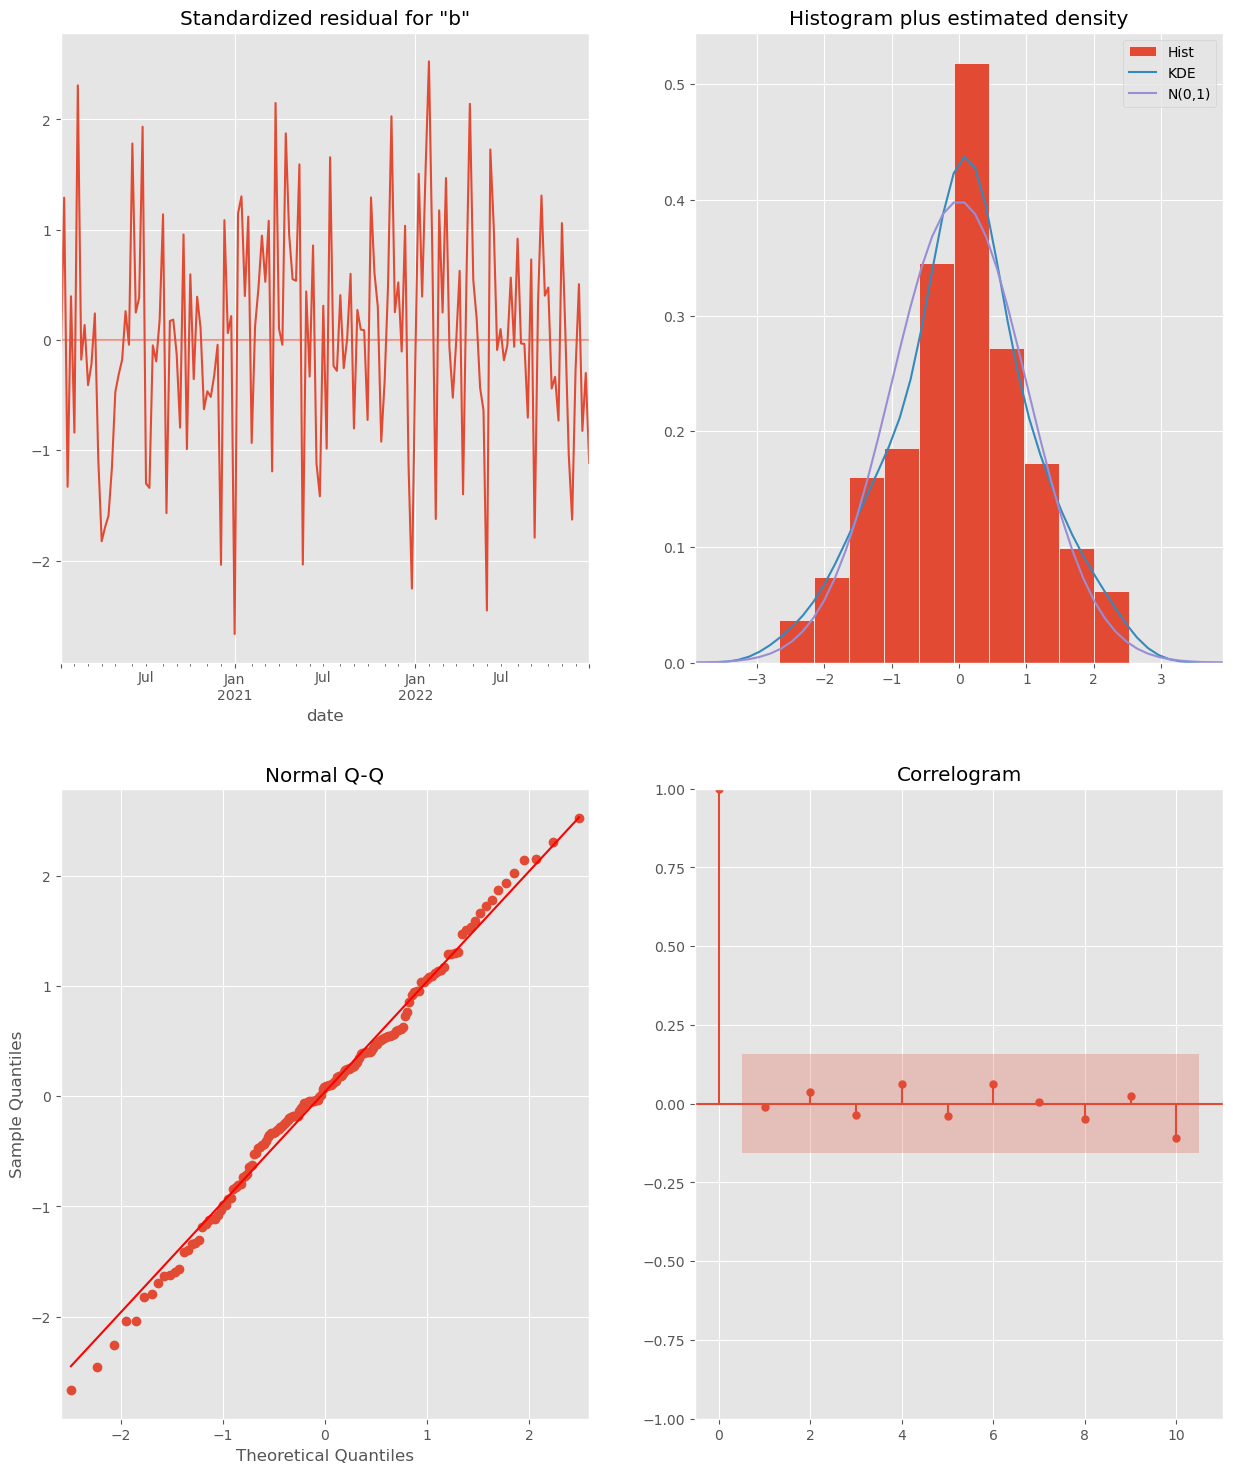

In [151]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [152]:
pred = output.get_prediction(start=pd.to_datetime('2022-01-07'), dynamic=True)
pred_conf = pred.conf_int()

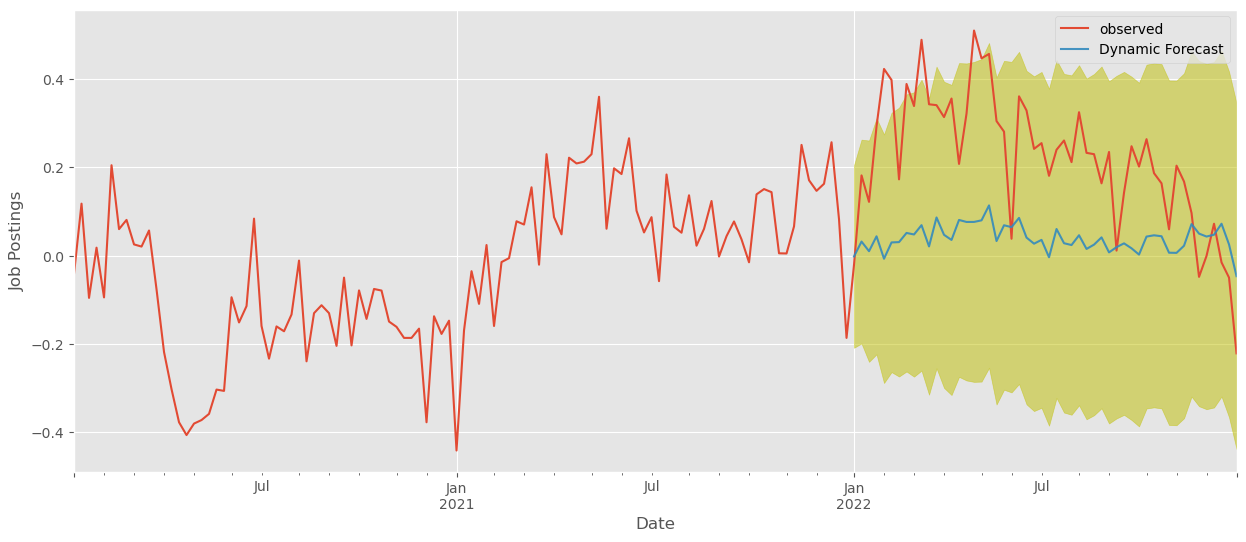

In [153]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6 #matplotlib runtime configuration

# Plot observed values
ax = df.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Job Postings')
plt.legend()

plt.show()

In [154]:
# Get the real and predicted values
jobs_forecasted = pred.predicted_mean
jobs_truth = df['2022-01-07':]

# Compute the mean square error
mse = ((jobs_forecasted - jobs_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.05


In [79]:
#jobs_forecasted[1] - jobs_truth[1]

In [80]:
# Get forecast 1yr ahead in future
prediction = output.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [544]:
#forecast = output.predict(start=df.shape[0], end=df.shape[0] + 8)
#forecast

In [81]:
prediction.predicted_mean[:10]

2023-01-06   -0.114719
2023-01-13   -0.055429
2023-01-20   -0.066422
2023-01-27   -0.015941
2023-02-03    0.023354
2023-02-10    0.021015
2023-02-17   -0.034971
2023-02-24    0.026671
2023-03-03    0.017052
2023-03-10    0.060688
Freq: W-FRI, Name: predicted_mean, dtype: float64

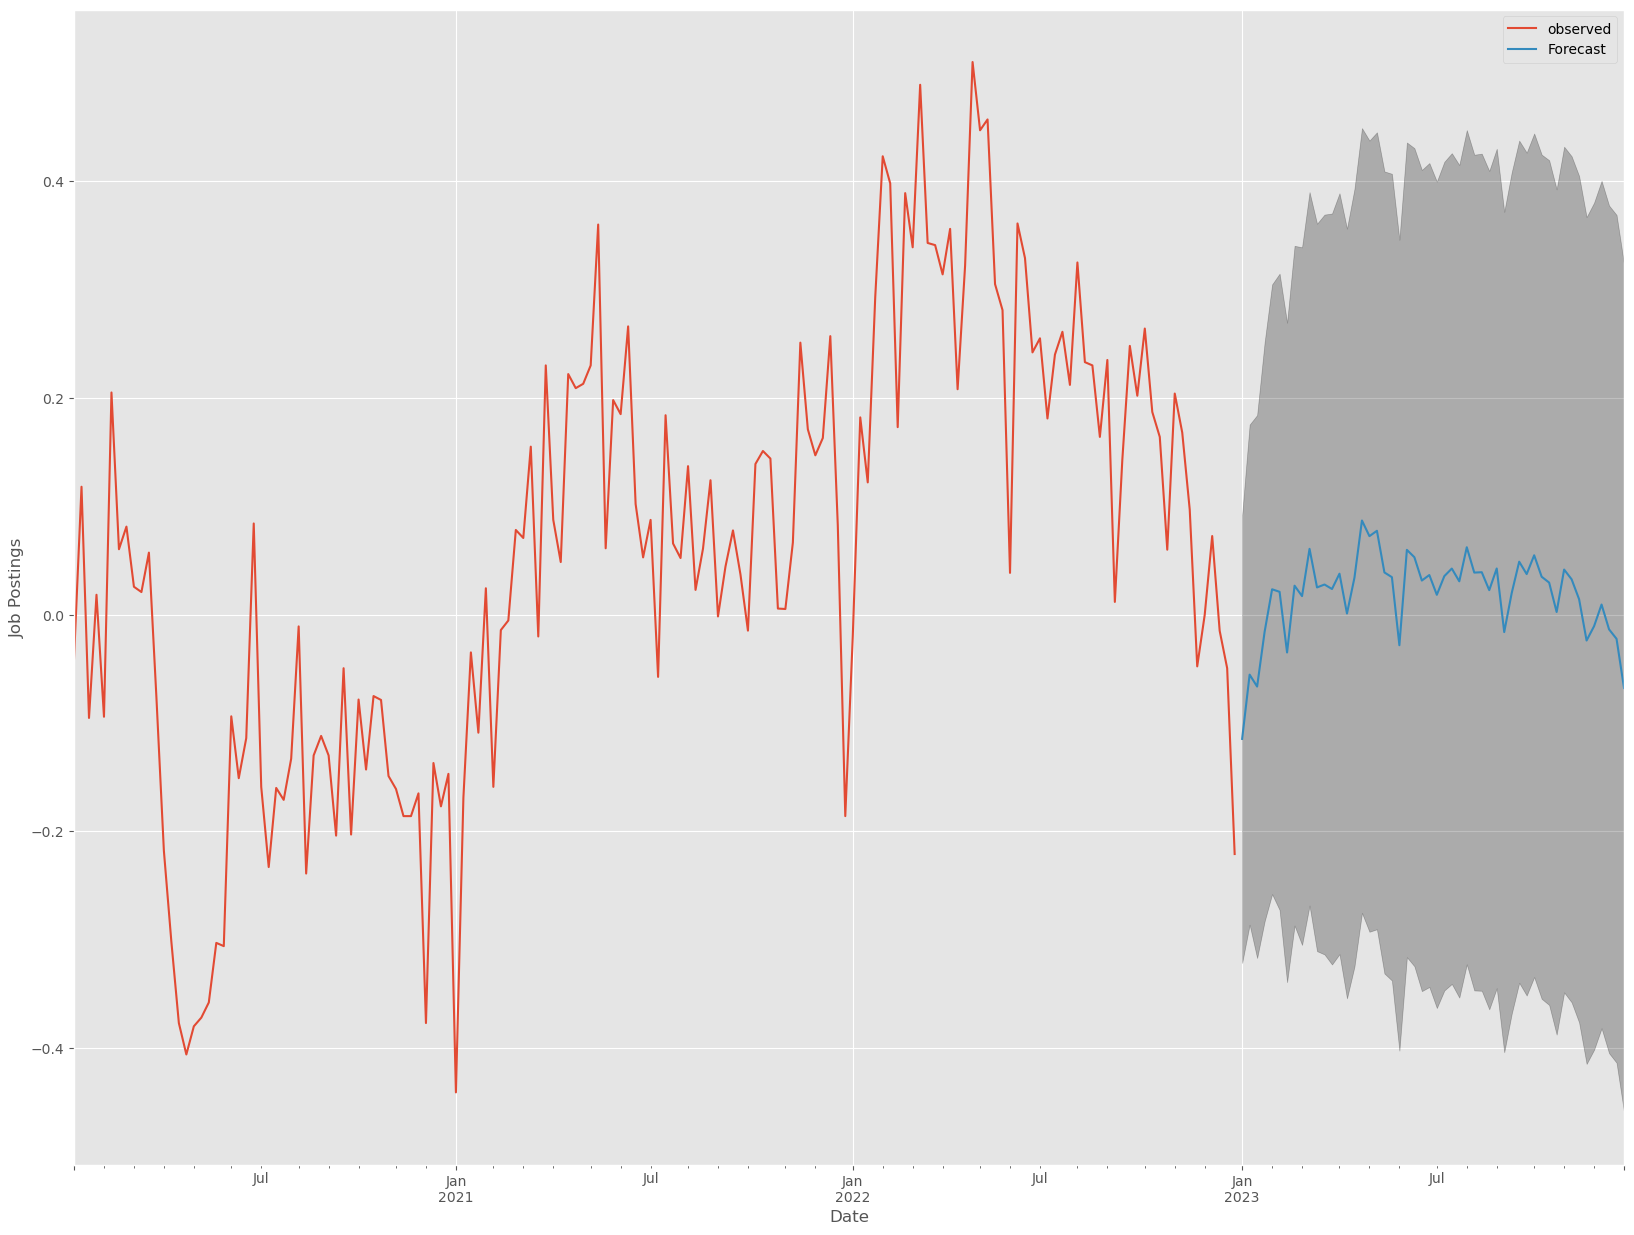

In [82]:
# Plot future predictions with confidence intervals
ax = df.plot(label='observed', figsize=(20, 15))

prediction.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Job Postings')

plt.legend()
plt.show()

#### Train Test Split

In [88]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [89]:
df.head() # weekly data

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

In [90]:
# data needs to stay in chronological order so we cut off last 80% and set aside for test
cutoff = round(df.shape[0]*0.8) 
cutoff

125

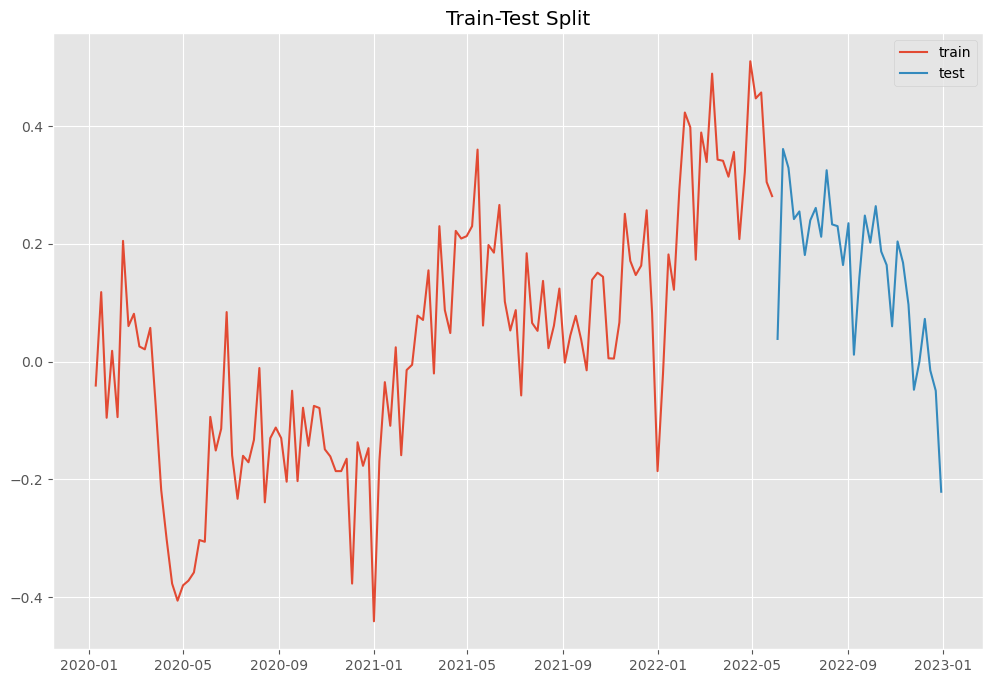

In [129]:
# train test split
train = df[:cutoff]
test = df[cutoff:]

# visualizing split
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [92]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] [45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] [65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84] [ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13

In [93]:
train_with_ind = train.reset_index()

In [185]:
order_52

(1, 0, 1)

In [94]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 0, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.11623070392021657
0.1658068259880681
0.18453464278901135
0.1281475316229865
0.37522835264206783


In [190]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.21855766439680074
0.19926201742447877
0.09911119738964623
0.10524074295630546
0.3981136068001826


In [189]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.30261965367816046
0.1954849863183548
0.10282301812443947
0.10566157420918747
0.3873463613596733


Our differenced series shows negative significant correlation at a lag of 1, which suggests adding 1 MA term

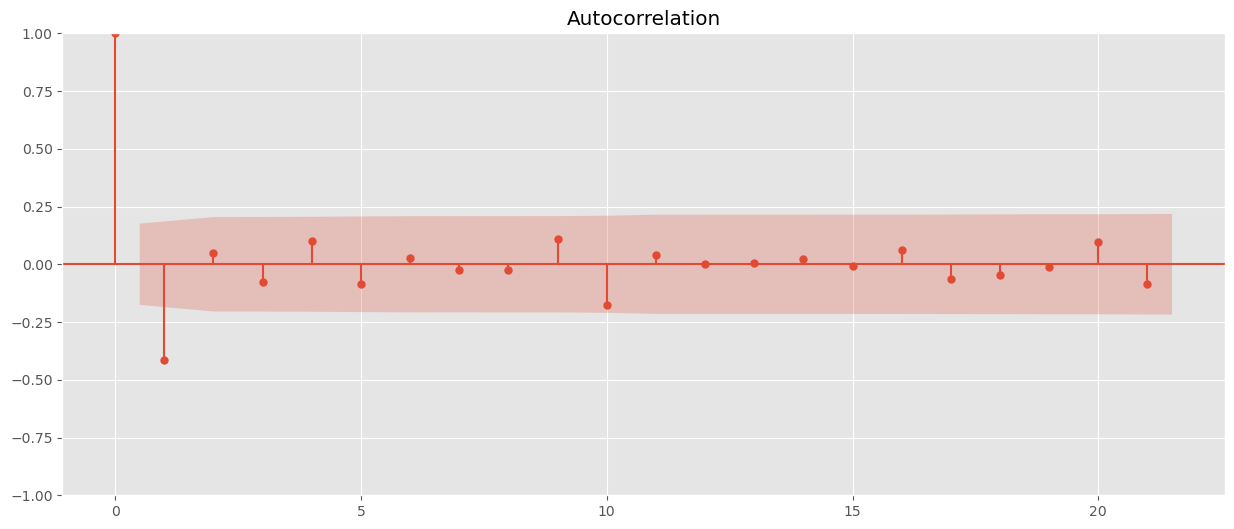

In [193]:
plot_acf(train.diff().dropna()); # 1 lag

- A sharp drop after lag "k" suggests an AR-k model. In this case, k=1
- A gradual decline suggests an MA.

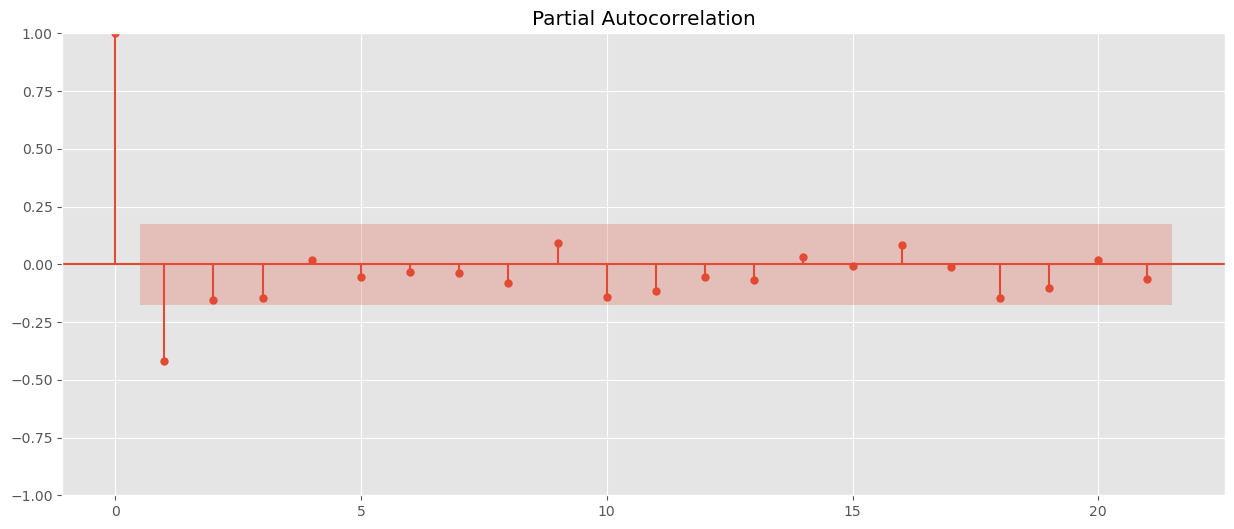

In [191]:
plot_pacf(train.diff().dropna()); 

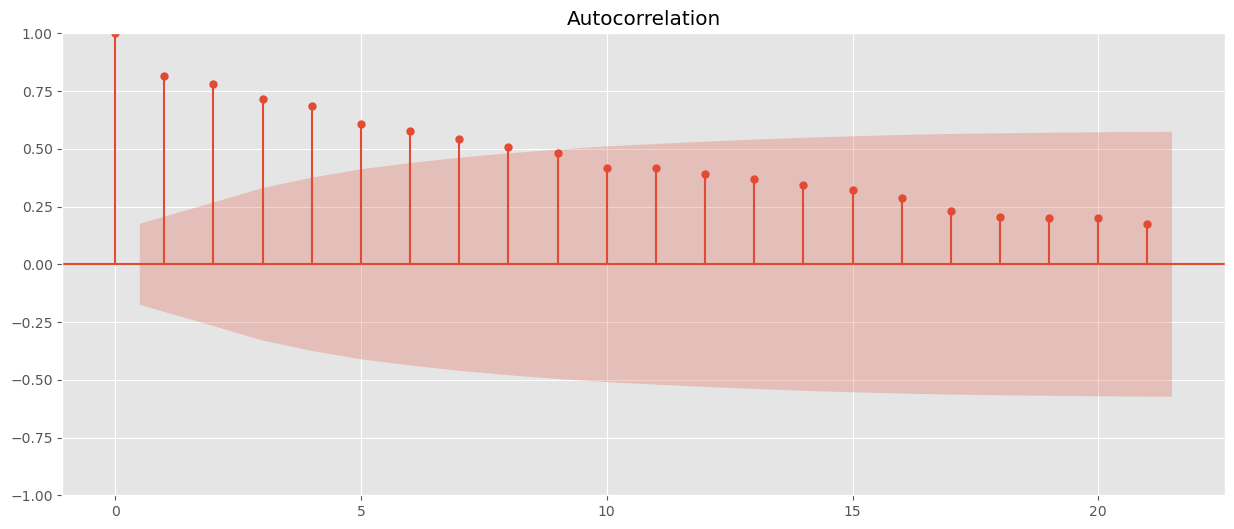

In [192]:
plot_acf(train); # period of 9-10 weeks

In [96]:
print(order)
seasonal_order

(1, 0, 1)


(1, 0, 0, 52)

In [131]:
# sari_mod = sm.tsa.statespace.SARIMAX(train,
#                                      order=order,
#                                      seasonal_order=seasonal_order,
#                                      enforce_stationarity=True,
#                                      enforce_invertibility=True).fit()

In [130]:
# display(sari_mod.summary())
# sari_mod.plot_diagnostics(figsize=(15, 18))
# plt.show()

Train / val on Sarima model

In [136]:
# dynamic
errors = []
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = sm.tsa.statespace.SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                                        order=order,
                                        seasonal_order=seasonal_order,
                                        enforce_stationarity=True,
                                        enforce_invertibility=True).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1], dynamic=True)
    true = train_with_ind.iloc[val_ind, -1]
    error = np.sqrt(mean_squared_error(true, preds))
    errors.append(error)

[0.16725511758360487, 0.14395392598863074, 0.15686205745801654, 0.11640142096106322, 0.3239794163805492]


In [ ]:
print(errors)

In [138]:
# static / one step ahead
errors = []
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = sm.tsa.statespace.SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                                        order=order,
                                        seasonal_order=seasonal_order,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1], dynamic=True)
    true = train_with_ind.iloc[val_ind, -1]
    error = np.sqrt(mean_squared_error(true, preds))
    errors.append(error)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.0

 This problem is unconstrained.



At iterate    5    f= -3.17669D-01    |proj g|=  6.02107D-01

At iterate   10    f= -3.31166D-01    |proj g|=  4.62468D-01

At iterate   15    f= -3.34393D-01    |proj g|=  3.22404D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   1.066D-05  -3.344D-01
  F = -0.33439304746691451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.42774D-01    |proj g|=  1.02686D+00


 This problem is unconstrained.



At iterate    5    f= -3.80381D-01    |proj g|=  2.73700D+00

At iterate   10    f= -4.09324D-01    |proj g|=  5.12258D-01

At iterate   15    f= -4.32449D-01    |proj g|=  1.08042D-01

At iterate   20    f= -4.32582D-01    |proj g|=  2.28824D-02

At iterate   25    f= -4.32616D-01    |proj g|=  2.70927D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   4.050D-05  -4.326D-01
  F = -0.43261644494866996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[0.18590659615007044,
 0.14090778202625834,
 0.18078085547767916,
 0.11392760504509068,
 0.32896169706255]

In [139]:
print(errors)

[0.18590659615007044, 0.14090778202625834, 0.18078085547767916, 0.11392760504509068, 0.32896169706255]


In [96]:
train.tail()

date
2022-04-29    0.510
2022-05-06    0.447
2022-05-13    0.457
2022-05-20    0.305
2022-05-27    0.281
Freq: W-FRI, Name: bg_posts, dtype: float64

In [140]:
#valid = train[val_ind[0]:]

# y_hat_train = sarimax.predict(typ='levels')
# y_hat_val = sarimax.predict(start=val_ind[0], end=val_ind[-1],typ='levels')

# fig, ax = plt.subplots()
# ax.plot(train, label='train')
# ax.plot(valid, label='validation') # valid
# ax.plot(y_hat_train, label='train_pred')
# ax.plot(y_hat_val, label='val_pred')

# plt.legend();

In [141]:
# # Let's zoom in on validation
# fig, ax = plt.subplots()

# ax.plot(valid, label='true')
# ax.plot(y_hat_val, label='pred')

# plt.legend();

In [105]:
# print(np.sqrt(mean_squared_error(valid, y_hat_val)))
# print(np.sqrt(mean_squared_error(train, y_hat_train)))

0.12100707023898231
0.10948173385866404


In [142]:
sari_mod = sm.tsa.statespace.SARIMAX(train,
                                     order=order,
                                     seasonal_order=seasonal_order,
                                     enforce_stationarity=True,
                                     enforce_invertibility=True).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57395D-01    |proj g|=  1.81562D-01


 This problem is unconstrained.



At iterate    5    f= -7.87491D-01    |proj g|=  2.13594D-02

At iterate   10    f= -7.87852D-01    |proj g|=  6.87789D-02

At iterate   15    f= -7.87870D-01    |proj g|=  6.99364D-03

At iterate   20    f= -7.88014D-01    |proj g|=  3.48942D-02

At iterate   25    f= -7.88384D-01    |proj g|=  8.53734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   8.556D-06  -7.884D-01
  F = -0.78838561286477582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


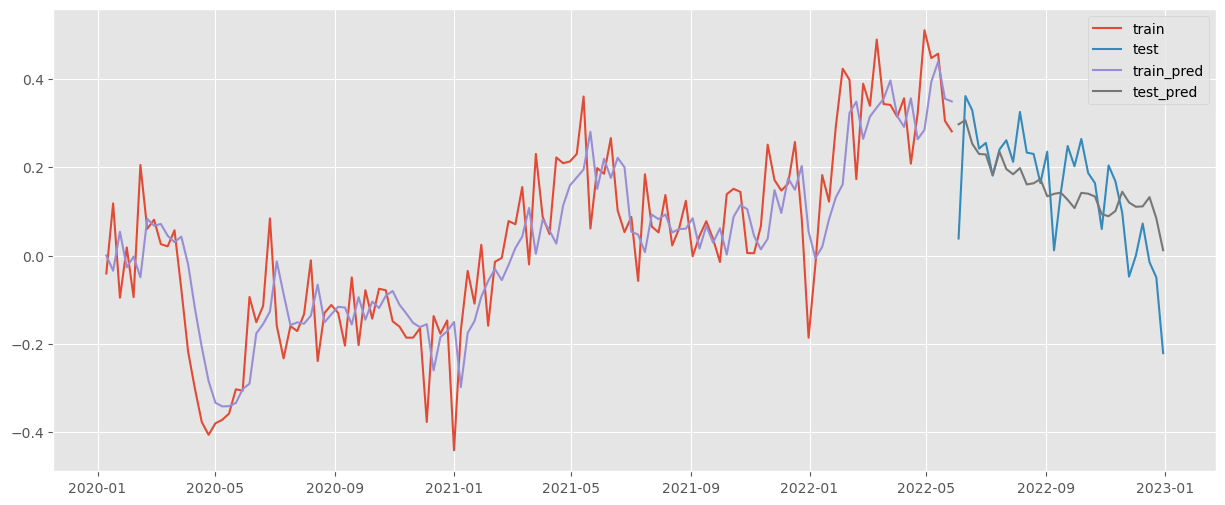

In [143]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels', dynamic=True)

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test') # valid
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

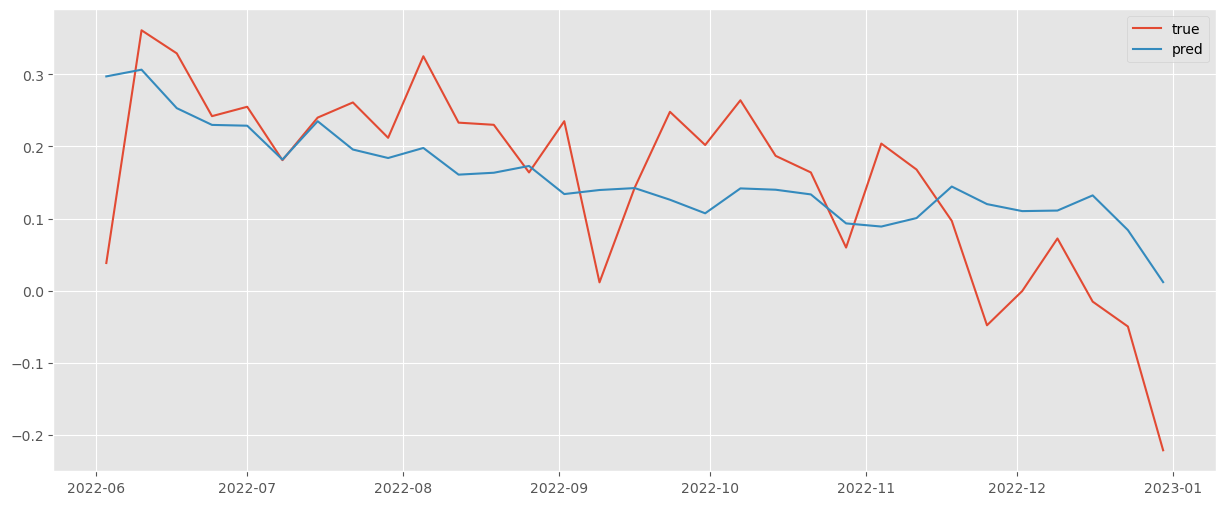

In [144]:
# Let's zoom in on validation
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [145]:
# sari_mod = sm.tsa.statespace.SARIMAX(train,
#                                      order=order,
#                                      seasonal_order=seasonal_order,
#                                      enforce_stationarity=True,
#                                      enforce_invertibility=True).fit()

In [146]:
sari_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            bg_posts   No. Observations:                  125
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                  98.548
Date:                             Tue, 24 Jan 2023   AIC                           -189.096
Time:                                     20:18:27   BIC                           -177.783
Sample:                                 01-10-2020   HQIC                          -184.500
                                      - 05-27-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9536      0.031     30.506      0.000       0.892       1.015
ma.L1         -0.4428      0.091     -4.870      0.000      -0.621      -0.265
ar.S.L52       0.2578      0.099      2.594      0.009       0.063       0.453
sigma2         0.0116      0.002      7.627      0.000       0.009       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.75   Prob(JB):                         0.95
Heteroskedasticity (H):               1.10   Skew:                            -0.06
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
y_hat_train = sari_mod.predict(typ='levels', dynamic=True)
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels', dynamic=True)

In [148]:
print(np.sqrt(mean_squared_error(train, y_hat_train)))
print(np.sqrt(mean_squared_error(test, y_hat_test)))

0.21240209731921197
0.10358723013923056


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02648D-01    |proj g|=  4.23456D-01


 This problem is unconstrained.



At iterate    5    f= -8.12667D-01    |proj g|=  2.18992D-02

At iterate   10    f= -8.12701D-01    |proj g|=  7.55498D-02

At iterate   15    f= -8.12755D-01    |proj g|=  1.08171D-03

At iterate   20    f= -8.12767D-01    |proj g|=  1.90905D-02

At iterate   25    f= -8.12834D-01    |proj g|=  1.09846D-02

At iterate   30    f= -8.12835D-01    |proj g|=  1.40499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   8.133D-06  -8.128D-01
  F = -0.81283538551282652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


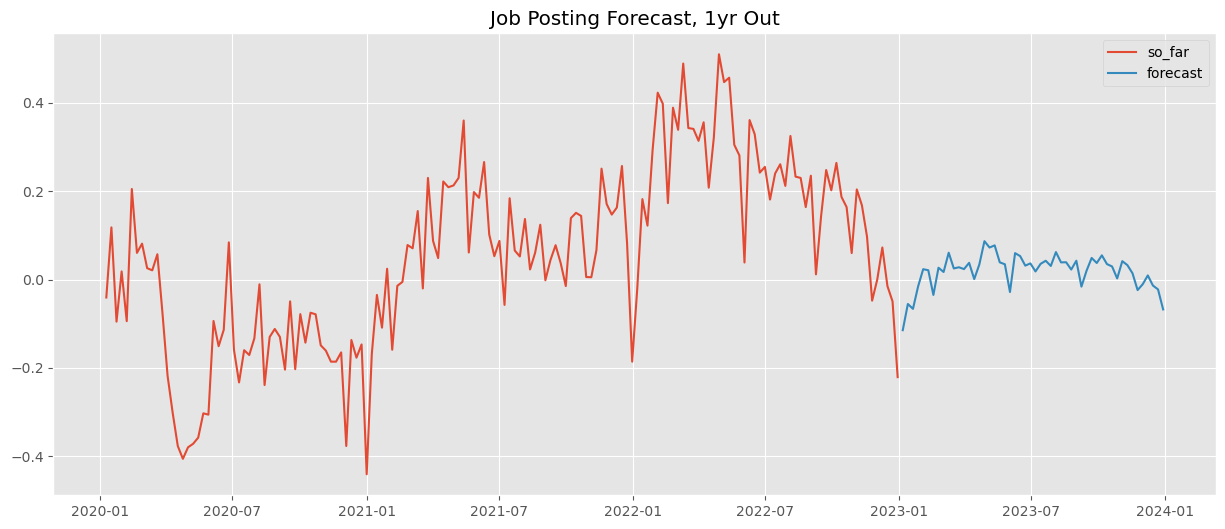

In [149]:
# Forecast

# training model on full series
sari_mod_final = sm.tsa.statespace.SARIMAX(df,
                                           order=order,
                                           seasonal_order=seasonal_order,
                                           enforce_stationarity=True,
                                           enforce_invertibility=True).fit()

forecast = sari_mod_final.forecast(steps=52, dynamic=True)

fig, ax = plt.subplots()
ax.plot(df, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Job Posting Forecast, 1yr Out')

plt.legend();

#### Facebook Prophet Model

In [408]:
from prophet import Prophet

In [565]:
df_prophet = job_postings_national[['date', 'bg_posts']]
df_prophet = df_prophet.rename(columns={'date': 'ds', 'bg_posts': 'y'})

In [566]:
Model = Prophet(interval_width=0.95)
Model.fit(df_prophet)

17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing


In [567]:
future_dates = Model.make_future_dataframe(periods=52, freq='W-SAT')
future_dates.tail()

,ds
203,2023-11-25
204,2023-12-02
205,2023-12-09
206,2023-12-16
207,2023-12-23


In [568]:
# Predict the values for future dates and take the head of forecast
forecast = Model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-10,-0.208884,-0.552839,-0.074961,-0.208884,-0.208884,-0.097315,-0.097315,-0.097315,-0.097315,-0.097315,-0.097315,0.0,0.0,0.0,-0.306200
1,2020-01-17,-0.205506,-0.388145,0.061553,-0.205506,-0.205506,0.039271,0.039271,0.039271,0.039271,0.039271,0.039271,0.0,0.0,0.0,-0.166235
2,2020-01-24,-0.202128,-0.311618,0.149671,-0.202128,-0.202128,0.119544,0.119544,0.119544,0.119544,0.119544,0.119544,0.0,0.0,0.0,-0.082583
3,2020-01-31,-0.198749,-0.289169,0.154841,-0.198749,-0.198749,0.126872,0.126872,0.126872,0.126872,0.126872,0.126872,0.0,0.0,0.0,-0.071877
4,2020-02-07,-0.195371,-0.323479,0.156889,-0.195371,-0.195371,0.108079,0.108079,0.108079,0.108079,0.108079,0.108079,0.0,0.0,0.0,-0.087291


In [569]:
# Subset above mentioned columns and view the tail 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
203,2023-11-25,0.343216,0.098608,0.588175
204,2023-12-02,0.360484,0.121522,0.600604
205,2023-12-09,0.361987,0.127966,0.602158
206,2023-12-16,0.320453,0.080495,0.552397
207,2023-12-23,0.259500,0.007886,0.499737


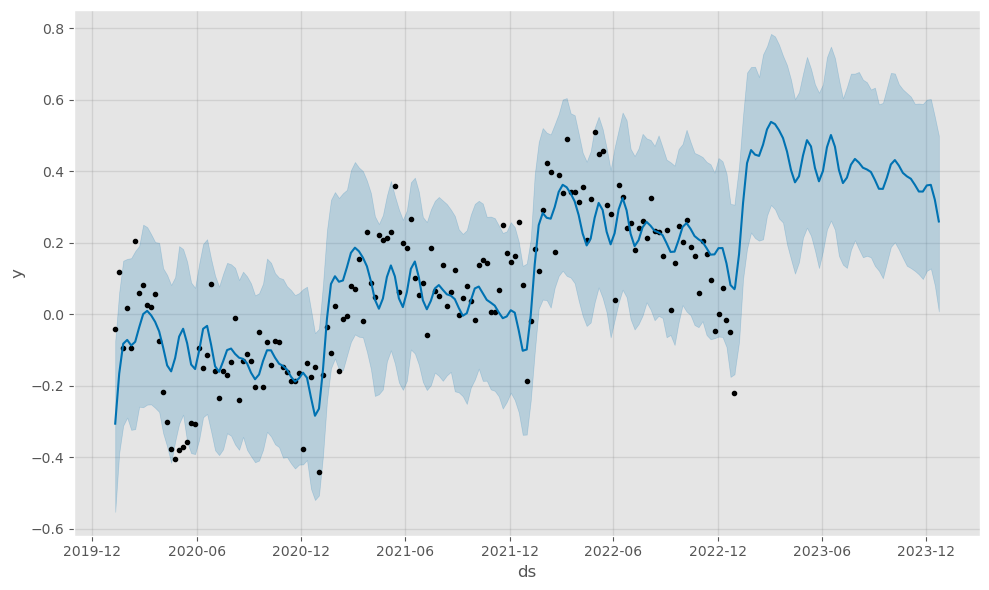

In [570]:
# Use Prophet's plot method to plot the predictions
Model.plot(forecast, uncertainty=True)
plt.show()

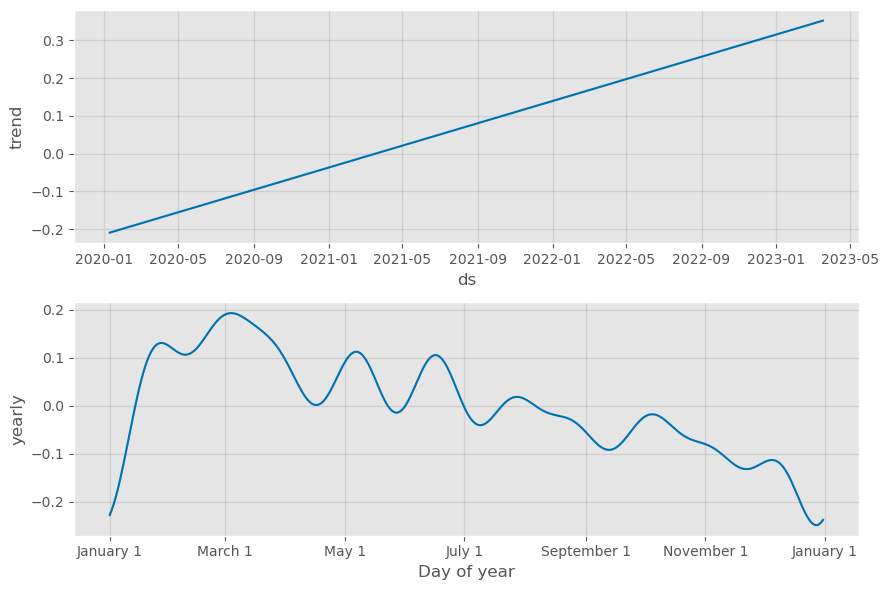

In [416]:
# Plot model components 
Model.plot_components(forecast)
plt.show()

#### ARMA Test

In [580]:
data_diff = df.diff().dropna()
data_diff

date
2020-01-17    0.158700
2020-01-24   -0.213400
2020-01-31    0.113700
2020-02-07   -0.112600
2020-02-14    0.299300
                ...   
2022-12-02    0.047469
2022-12-09    0.072831
2022-12-16   -0.087500
2022-12-23   -0.034500
2022-12-30   -0.171500
Freq: W-FRI, Name: bg_posts, Length: 155, dtype: float64

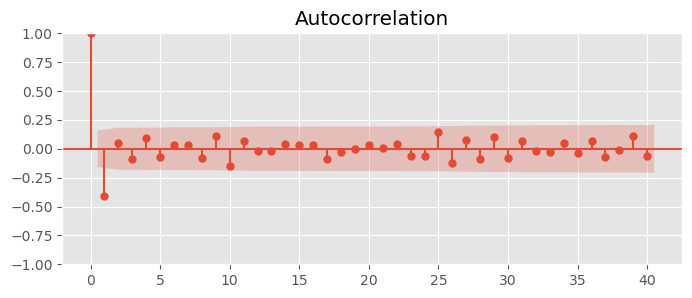

In [594]:
# Plot the ACF
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(data_diff,ax=ax, lags=40);

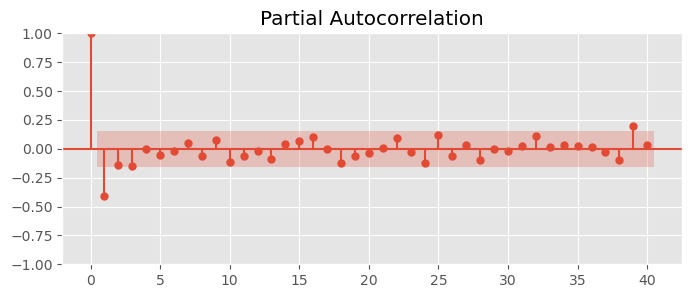

In [595]:
# Plot the PACF
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(data_diff,ax=ax, lags=40);

In [592]:
# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARMA(1,0) model
mod_arma = ARIMA(data_diff, order=(1,1,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:               bg_posts   No. Observations:                  155
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  67.705
Date:                Thu, 19 Jan 2023   AIC                           -131.410
Time:                        17:58:28   BIC                           -125.337
Sample:                    01-17-2020   HQIC                          -128.943
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6679      0.058    -11.597      0.000      -0.781      -0.555
sigma2         0.0242      0.003      8.084      0.000       0.018       0.030
Ljung-Box (L1) (Q):                  10.48   Jarque-

In [601]:
# Fit an ARMA(1,0) model
mod_arma = ARIMA(data_diff, order=(0,0,1))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:               bg_posts   No. Observations:                  155
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 120.994
Date:                Thu, 19 Jan 2023   AIC                           -235.987
Time:                        18:03:07   BIC                           -226.857
Sample:                    01-17-2020   HQIC                          -232.279
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.004     -0.172      0.863      -0.009       0.008
ma.L1         -0.5080      0.064     -7.903      0.000      -0.634      -0.382
sigma2         0.0123      0.001      8.909      0.0

# Regression

When you are modeling for prediction, you are asking the question "How well can I use X (independent variables or features) to predict Y (dependent or target or outcome variable)?" Thus, in this case, you are less concerned about how and which features impact Y as opposed to how you can efficiently use them to predict Y.

When modeling for prediction, you typically use all available features (and most likely engineer new features) because you are trying to accurately predict Y, at all costs. As a result, you are less concerned about the coefficients of these features and instead focus on the overall accuracy of the model.

target = layoffs 
inputs:
- sector
- econ data
- job postings by sector?
- business openings?
- some measure of revenues

Regression for each sector?

Classification - given one layoff, prob of second?

In [168]:
layoffs.company.value_counts()[layoffs.company.value_counts() > 1]

Loft              5
Swiggy            5
OYO               5
Uber              5
Crypto.com        4
                 ..
Bird              2
100 Thieves       2
ThirdLove         2
StreamElements    2
Rivian            2
Name: company, Length: 282, dtype: int64

In [166]:
print(len(layoffs))

2047


In [ ]:
layoffs['multiple'] = [1 for ]

In [11]:
total_layoffs_by_month.head()

,total_laid_off
month,
2020-03-01,9628.0
2020-04-01,26710.0
2020-05-01,25804.0
2020-06-01,7627.0
2020-07-01,7112.0


In [15]:
pd.to_datetime(total_layoffs_by_month.index)

DatetimeIndex(['2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='month', freq=None)

In [16]:
df_monthly = total_layoffs_by_month

# index needs to be DatetimeIndex named "date"
if isinstance(df_monthly.index, pd.DatetimeIndex):
    df_monthly.index.name = 'date'
else:
    df_monthly.index = pd.to_datetime(df_monthly.index)
    df_monthly.index.name = 'date'
    
    #df_monthly.rename(columns={'index':'date'}, inplace=True)
    #df_monthly.set_index('month', inplace=True)

In [17]:
isinstance(df_monthly.index, pd.DatetimeIndex)

True

In [18]:
# setting frequency to monthly and backfilling any missing values

#df_monthly = df_monthly.asfreq('MS')
df_monthly = df_monthly.fillna(df_monthly.bfill())
df_monthly = df_monthly['total_laid_off'].resample('MS').mean()

In [19]:
df_monthly.head()

date
2020-03-01     9628.0
2020-04-01    26710.0
2020-05-01    25804.0
2020-06-01     7627.0
2020-07-01     7112.0
Freq: MS, Name: total_laid_off, dtype: float64

In [42]:
df_weekly = layoffs[['day', 'total_laid_off']]

# Make sure that index is DatetimeIndex named "date"
if isinstance(df_weekly.index, pd.DatetimeIndex):
    df_weekly.index.name = 'date'
else:
    df_weekly.rename(columns={'index':'date'}, inplace=True)
    df_weekly.set_index('day', inplace=True)
    
    
df_weekly = df_weekly['total_laid_off'].resample('W').sum()
df_weekly.head()

day
2020-03-15     109.0
2020-03-22    1315.0
2020-03-29    6400.0
2020-04-05    6643.0
2020-04-12    6652.0
Freq: W-SUN, Name: total_laid_off, dtype: float64

<AxesSubplot: >

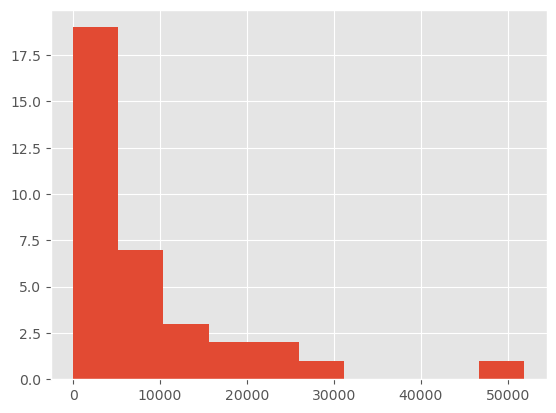

In [45]:
df_monthly.hist()

<AxesSubplot: >

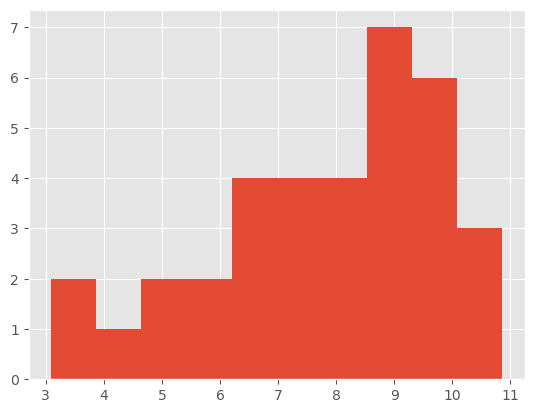

In [46]:
np.log(df_monthly).hist()

In [47]:
df_log = np.log(df_monthly)
df_log.head()

month
2020-03-01     9.172431
2020-04-01    10.192793
2020-05-01    10.158285
2020-06-01     8.939450
2020-07-01     8.869539
Freq: MS, Name: total_laid_off, dtype: float64

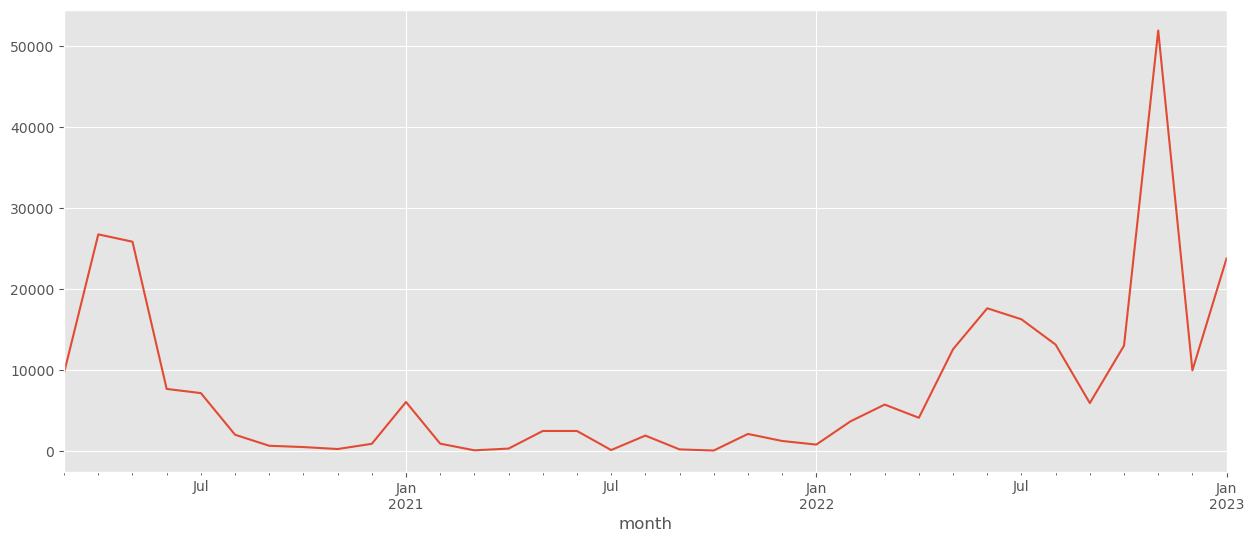

month
2020-03-01     9628.0
2020-04-01    26710.0
2020-05-01    25804.0
2020-06-01     7627.0
2020-07-01     7112.0
Freq: MS, Name: total_laid_off, dtype: float64


In [48]:
df_monthly.plot(figsize=(15, 6))
plt.show()
print(df_monthly.head())

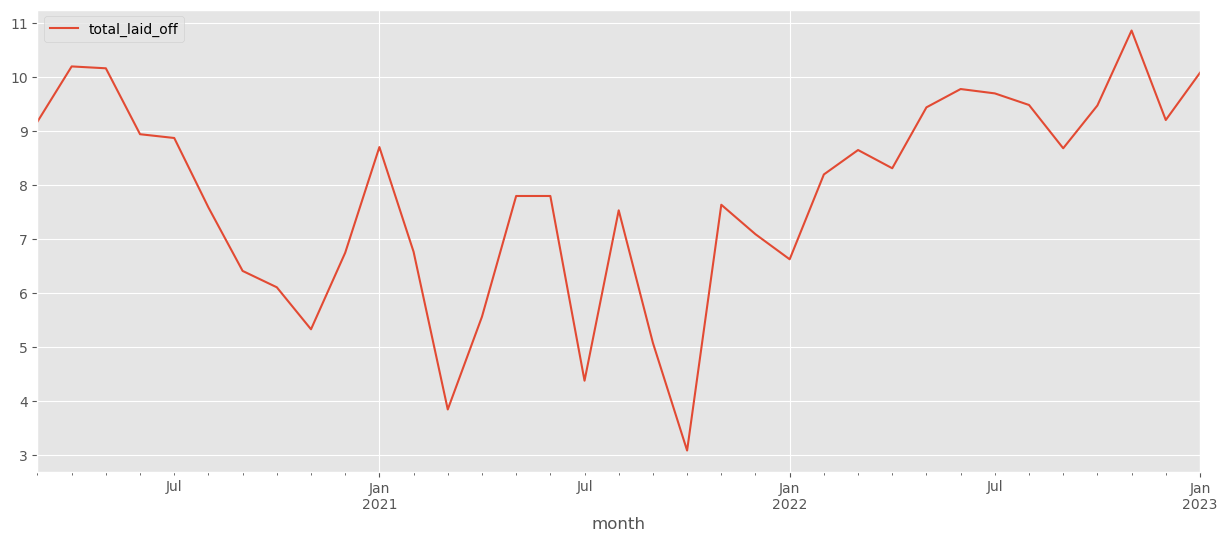

            total_laid_off
month                     
2020-03-01          9628.0
2020-04-01         26710.0
2020-05-01         25804.0
2020-06-01          7627.0
2020-07-01          7112.0


In [180]:
df_log.plot(figsize=(15, 6))
plt.show()
print(df.head())

# Appendix

### Adding Exog

In [203]:
# start date needs to be on or after 3/15/2020
# end date needs to be on or before 12/30/2022
display(df.head())
display(df.tail())
display(df_weekly.head())
display(df_weekly.tail())

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

date
2022-12-02   -0.000331
2022-12-09    0.072500
2022-12-16   -0.015000
2022-12-23   -0.049500
2022-12-30   -0.221000
Freq: W-FRI, Name: bg_posts, dtype: float64

day
2020-03-15     109.0
2020-03-22    1315.0
2020-03-29    6400.0
2020-04-05    6643.0
2020-04-12    6652.0
Freq: W-SUN, Name: total_laid_off, dtype: float64

day
2022-12-18     1989.0
2022-12-25      836.0
2023-01-01      150.0
2023-01-08    18392.0
2023-01-15     5358.0
Freq: W-SUN, Name: total_laid_off, dtype: float64

In [204]:
df_layoffs = layoffs[['day', 'total_laid_off']]

# Make sure that index is DatetimeIndex named "date"
if isinstance(df_layoffs.index, pd.DatetimeIndex):
    df_layoffs.index.name = 'date'
else:
    df_layoffs.rename(columns={'index':'date'}, inplace=True)
    df_layoffs.set_index('day', inplace=True)
    
    
df_layoffs = df_layoffs['total_laid_off'].resample('W-FRI').sum()
df_layoffs.head()

day
2020-03-13     109.0
2020-03-20    1315.0
2020-03-27    5473.0
2020-04-03    7480.0
2020-04-10    6742.0
Freq: W-FRI, Name: total_laid_off, dtype: float64

In [205]:
df_postings = df['2020-03-13':]
df_postings.head()

date
2020-03-13    0.0208
2020-03-20    0.0572
2020-03-27   -0.0760
2020-04-03   -0.2180
2020-04-10   -0.3020
Freq: W-FRI, Name: bg_posts, dtype: float64

In [ ]:
df_log_layoffs = df_layoffs[:'2023-01-01']
df_layoffs.tail()

In [214]:
df_log_layoffs = np.log(df_layoffs[:'2023-01-01']).fillna(value=0)

day
2022-12-02    2.143833
2022-12-09    2.167912
2022-12-16    2.031638
2022-12-23    1.906371
2022-12-30    1.611563
Freq: W-FRI, Name: total_laid_off, dtype: float64

In [218]:
mod_exog = sm.tsa.statespace.SARIMAX(endog=df_postings,
                                     exog=df_layoffs,
                                     order=order_52,
                                     seasonal_order=seasonal_order_52).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.87238D-01    |proj g|=  4.61113D-01

At iterate    5    f= -8.15711D-01    |proj g|=  2.05640D-01

At iterate   10    f= -8.15890D-01    |proj g|=  4.44269D-02

At iterate   15    f= -8.15944D-01    |proj g|=  3.65224D-03

At iterate   20    f= -8.15944D-01    |proj g|=  1.77664D-03

At iterate   25    f= -8.15954D-01    |proj g|=  1.91002D-03

At iterate   30    f= -8.15959D-01    |proj g|=  1.20183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

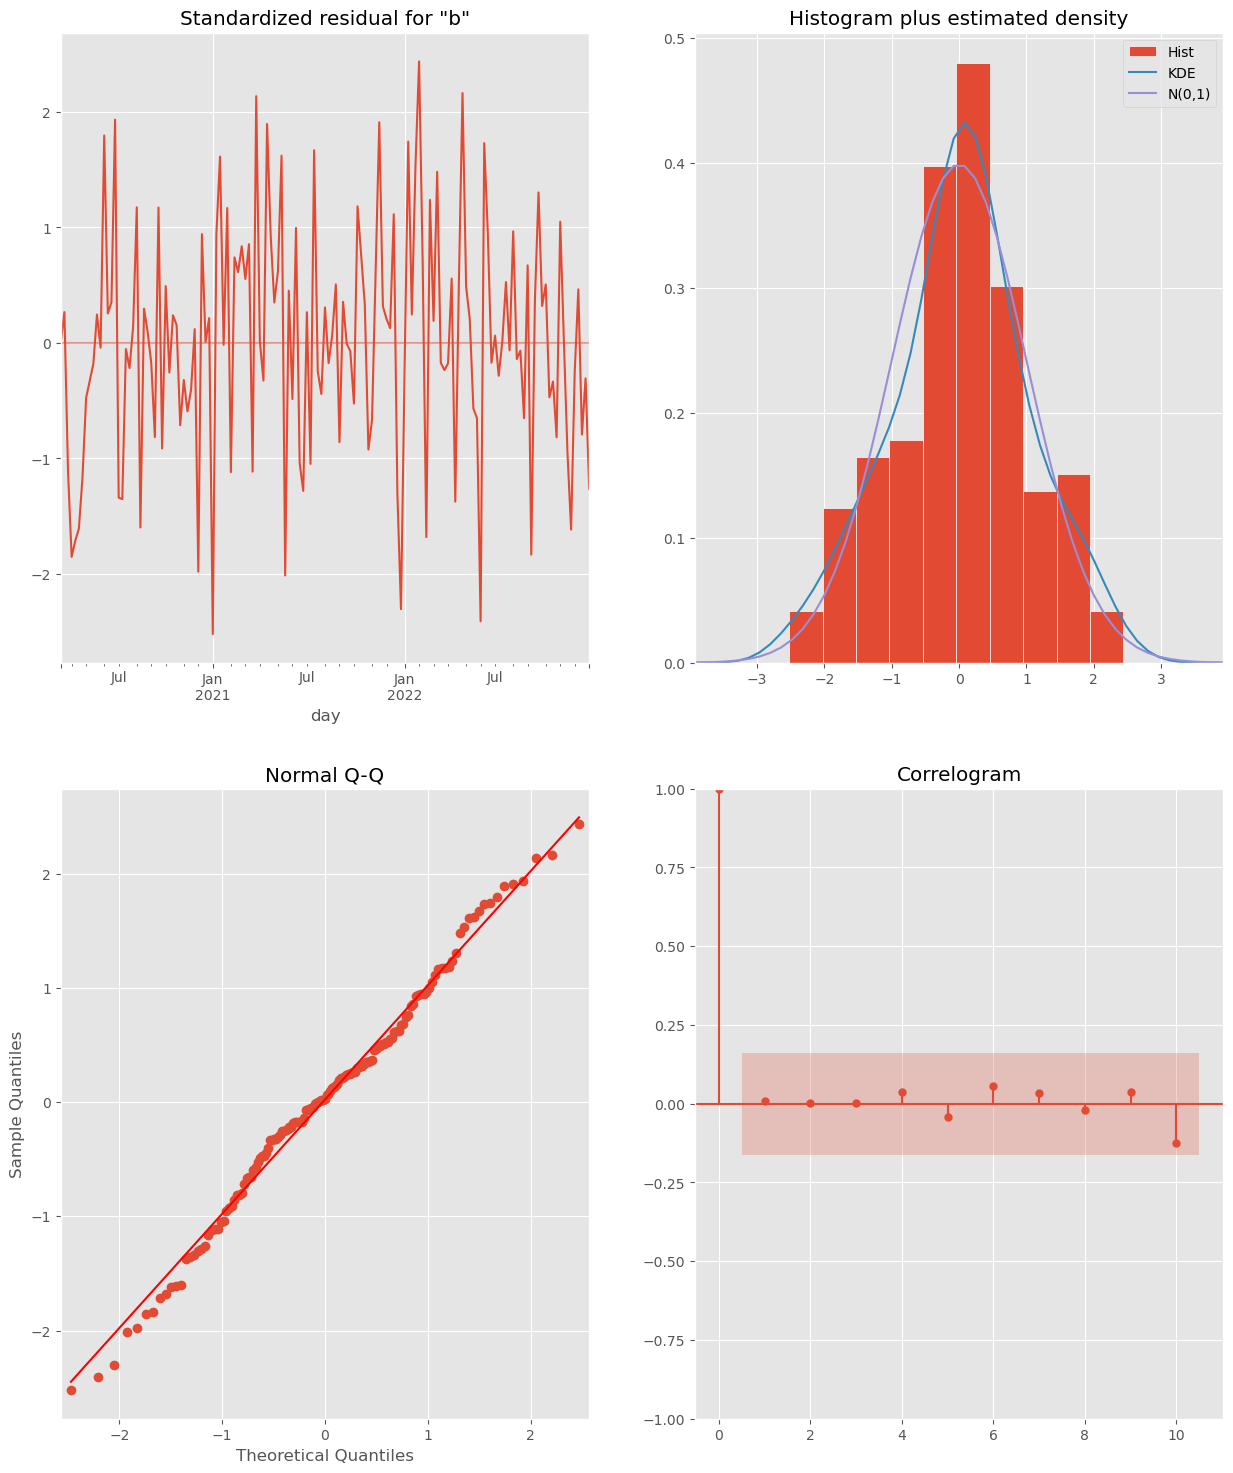

In [219]:
mod_exog.plot_diagnostics(figsize=(15, 18))
plt.show()

In [220]:
mod_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            bg_posts   No. Observations:                  147
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                 119.946
Date:                             Fri, 20 Jan 2023   AIC                           -229.892
Time:                                     17:24:40   BIC                           -214.940
Sample:                                 03-13-2020   HQIC                          -223.817
                                      - 12-30-2022                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
total_laid_off     0.0130      0.014      0.904      0.366      -0.015       0.041
ar.L1              0.9524      0.026     36.804      0.000       0.902       1.003
ma.L1             -0.4495      0.076     -5.947      0.000      -0.598      -0.301
ar.S.L52           0.2168      0.092      2.348      0.019       0.036       0.398
sigma2             0.0111      0.001      8.208      0.000       0.008       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.92   Prob(JB):                         0.84
Heteroskedasticity (H):               1.00   Skew:                            -0.11
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [225]:
pred = mod_exog.get_prediction(start=pd.to_datetime('2022-01-07'), dynamic=False, exog=df_layoffs['2022-01-07':])
pred_conf = pred.conf_int()

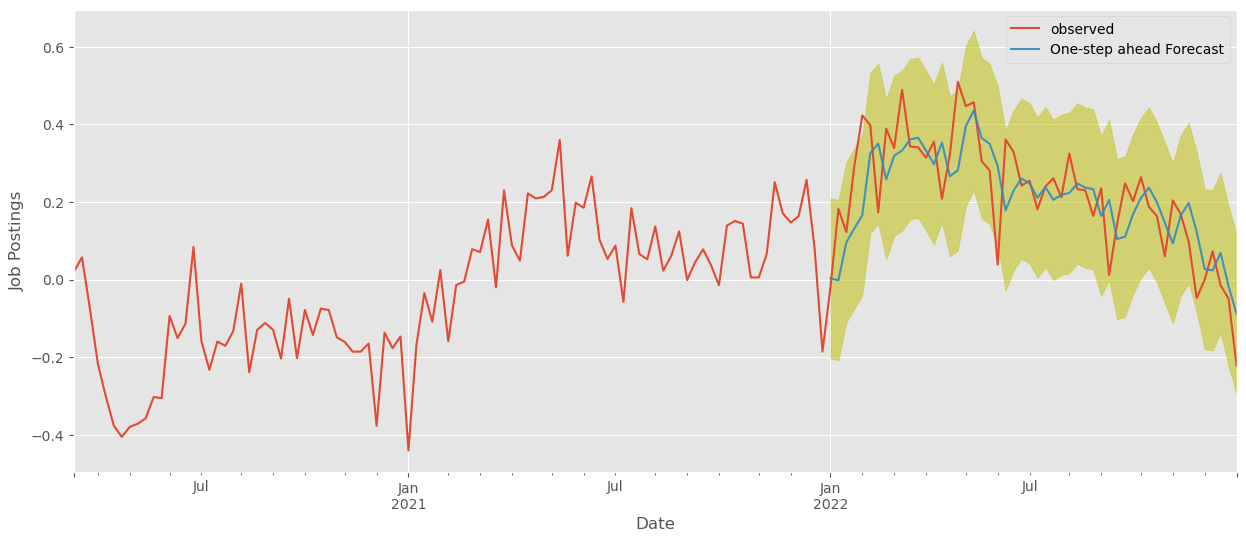

In [226]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6 #matplotlib runtime configuration

# Plot observed values
ax = df_postings.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Job Postings')
plt.legend()

plt.show()

In [227]:
# Get the real and predicted values
jobs_forecasted = pred.predicted_mean
jobs_truth = df_layoffs['2022-01-07':]

# Compute the mean square error
mse = ((jobs_forecasted - jobs_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3.09


https://github.com/statsmodels/statsmodels/issues/4284

EXOG ISSUES

In [224]:
forecast = mod_exog.predict(start=df.shape[0], end=df.shape[0] + 8, exog=df_layoffs)
forecast

ValueError: Provided exogenous values are not of the appropriate shape. Required (18, 1), got (147,).

In [221]:
# Get forecast 1yr ahead in future
prediction = mod_exog.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [222]:
forecast = mod_exog.forecast(steps=52)

fig, ax = plt.subplots()
ax.plot(df, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Job Posting Forecast, 1yr Out')

plt.legend();

ValueError: Provided exogenous values are not of the appropriate shape. Required (52, 1), got (147,).